In [205]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
import os

os.chdir('..')
os.chdir('results')

In [275]:
def get_path(dataset='FordA', model_name='ResidualCNN', reg=True, exp_name=None):
    attack_type = 'fgsm_disc_attack' if reg else 'fgsm_attack'
    exp = '_' + exp_name if exp_name else ''
    
    path = '/'.join([dataset, model_name, 'attack', attack_type + exp])

    return path



def combined_df(dataset='FordA', model_name='ResidualCNN', reg=True, exp_name=None):

    path = get_path(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)
    
    files = os.listdir(path)
    files = [f for f in files if f.endswith('.csv')]

    pattern = r"(?<==).*?(?=.csv)"
    id_pattern = fr"(?<={dataset}_).*?(?=_alpha)"

    all_res = pd.DataFrame()

    for file in files:
        curr_res = pd.read_csv(path + '/' + file, index_col=0)

        curr_res['alpha'] = float(re.search(pattern, file)[0])
        curr_res['model_id'] = re.search(id_pattern, file)[0]

        curr_res.columns = [column.strip(' ') for column in curr_res.columns] 

        all_res = pd.concat([all_res, curr_res], axis=0)

    return all_res.reset_index(drop=True)



def aggregated_results(
    dataset='FordA', 
    model_name='ResidualCNN', 
    exp_name='',
    reg=True,  
    metr='F_EFF_CONC',
    metr_max=True,
    k=1,
    vis = False,
    figsize=(20, 30),
    save_pic=False):

    all_df = combined_df(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)

    grouped = all_df.groupby(['eps', 'alpha'])
    result = grouped.apply(lambda x: x.nlargest(k, metr, keep='last') if metr_max else x.nsmallest(k, metr, keep='last'))


    if vis:
        
        fig, ax = plt.subplots(result['alpha'].nunique(), result['eps'].nunique(), figsize=figsize, sharey=True)
        fig.suptitle(f'{dataset}_{model_name}')

        all_alps = result['alpha'].unique()
        all_eps = result['eps'].unique()

        path = get_path(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)

        for i, row in result.iterrows():

            alp = int(row['alpha']) if row['alpha'].is_integer() else row['alpha']
            eps = row['eps']

            file_path = path + '/' + f'aa_res_{dataset}_{int(row["model_id"])}_alpha={alp}.csv'

            curr_df = pd.read_csv(file_path, index_col=0)
            curr_df.columns = [column.strip(' ') for column in curr_df.columns]

            curr_df = curr_df[curr_df['eps']==eps].set_index('step_id')

            eps_id = np.where(all_eps==eps)[0][0]
            alp_id = np.where(all_alps==alp)[0][0]

            ax[alp_id, eps_id].plot(curr_df[['ACC', 'PROB_HID']])
            ax[alp_id, eps_id].axvline(int(row["step_id"]), ls='--', alpha=0.2, color='black')

            ax[alp_id, eps_id].set_title(f'eps={eps}, alpha={alp}, {metr}={row[metr]}, step={int(row["step_id"])}')
            ax[alp_id, eps_id].legend(['ACC', 'PROB_HID'])
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)

        if save_pic:
            plt.savefig(f'../{dataset}_{model_name}.jpeg', dpi=120)

    return result

GunPointMaleVersusFemale LSTM
FreezerRegularTrain LSTM
FordA TST


<ipython-input-275-0437b46fec51>:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(result['alpha'].nunique(), result['eps'].nunique(), figsize=figsize, sharey=True)


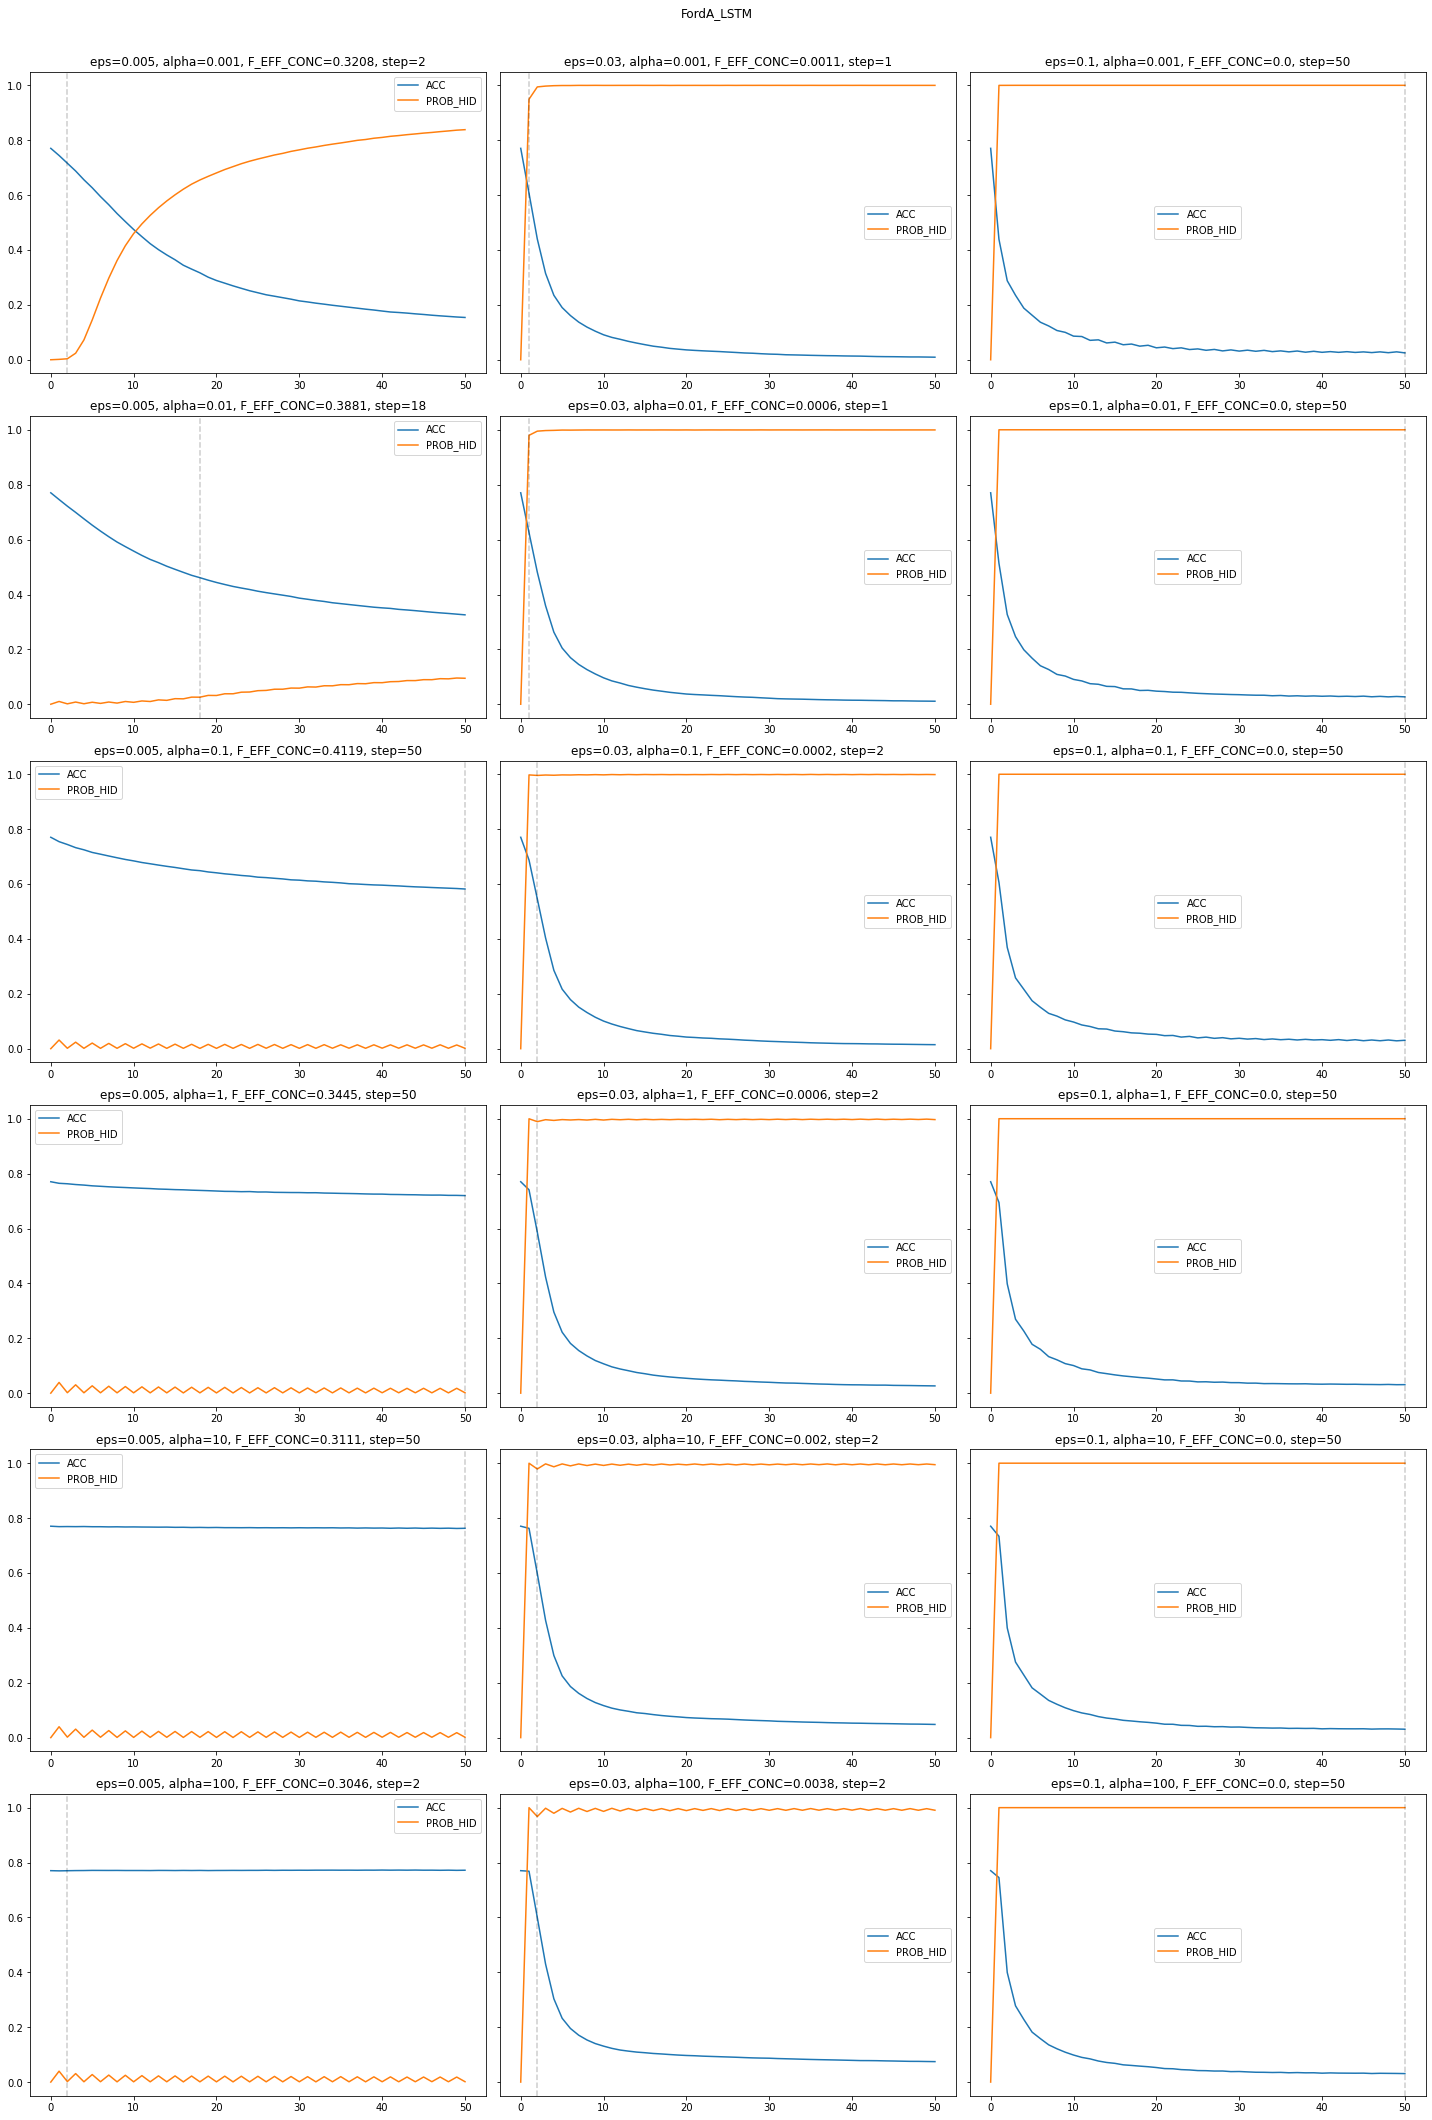

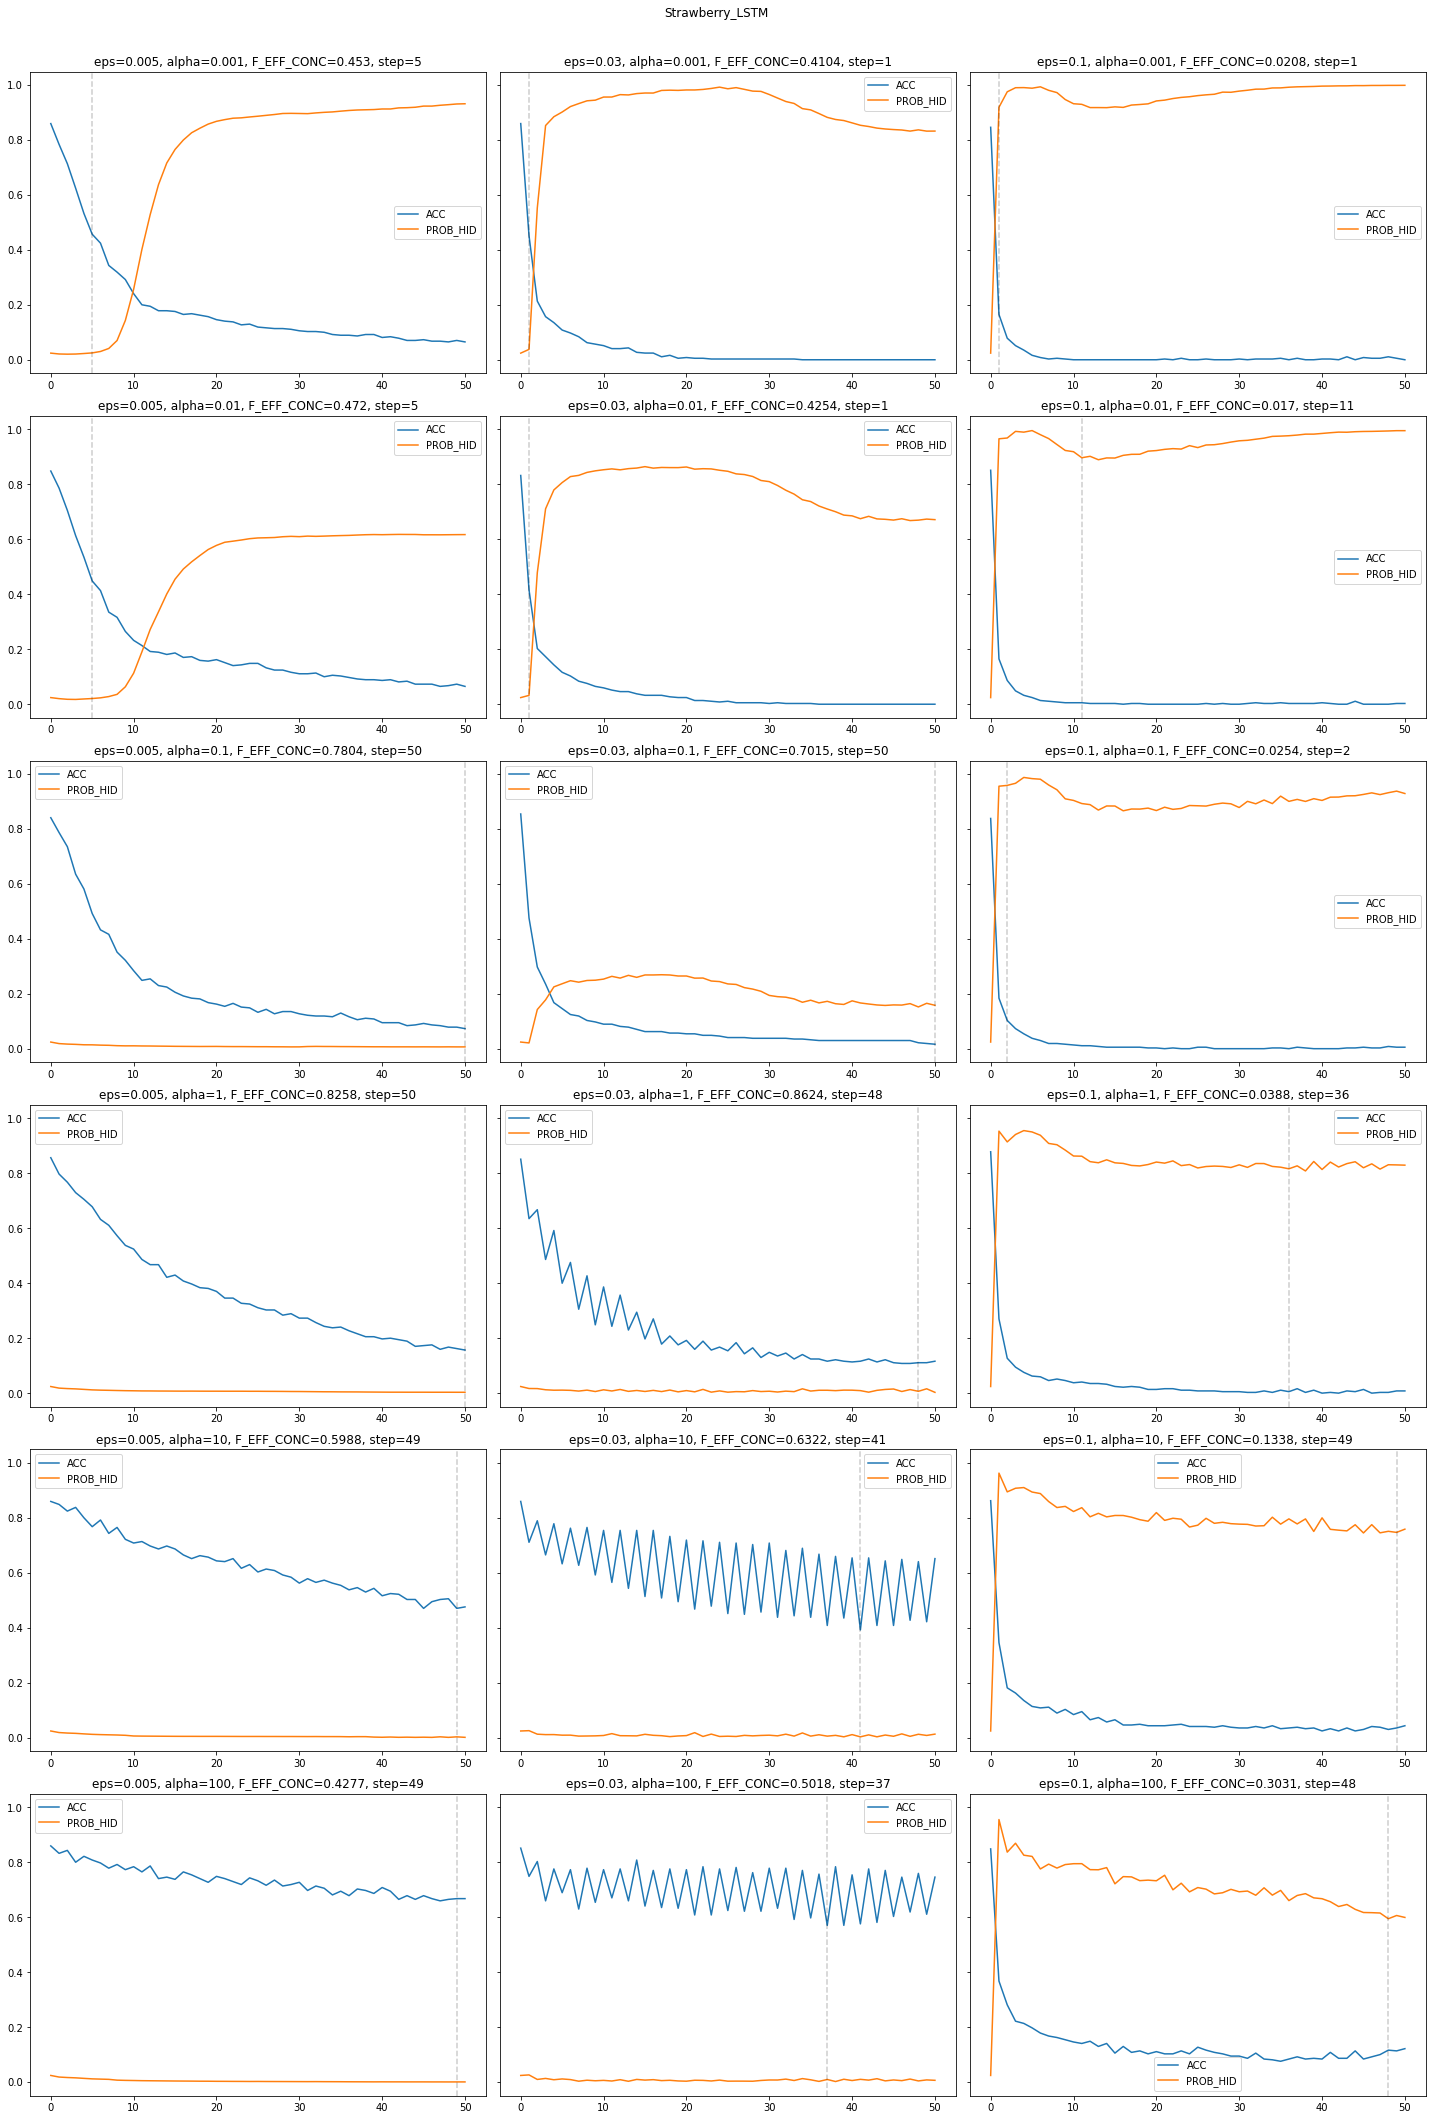

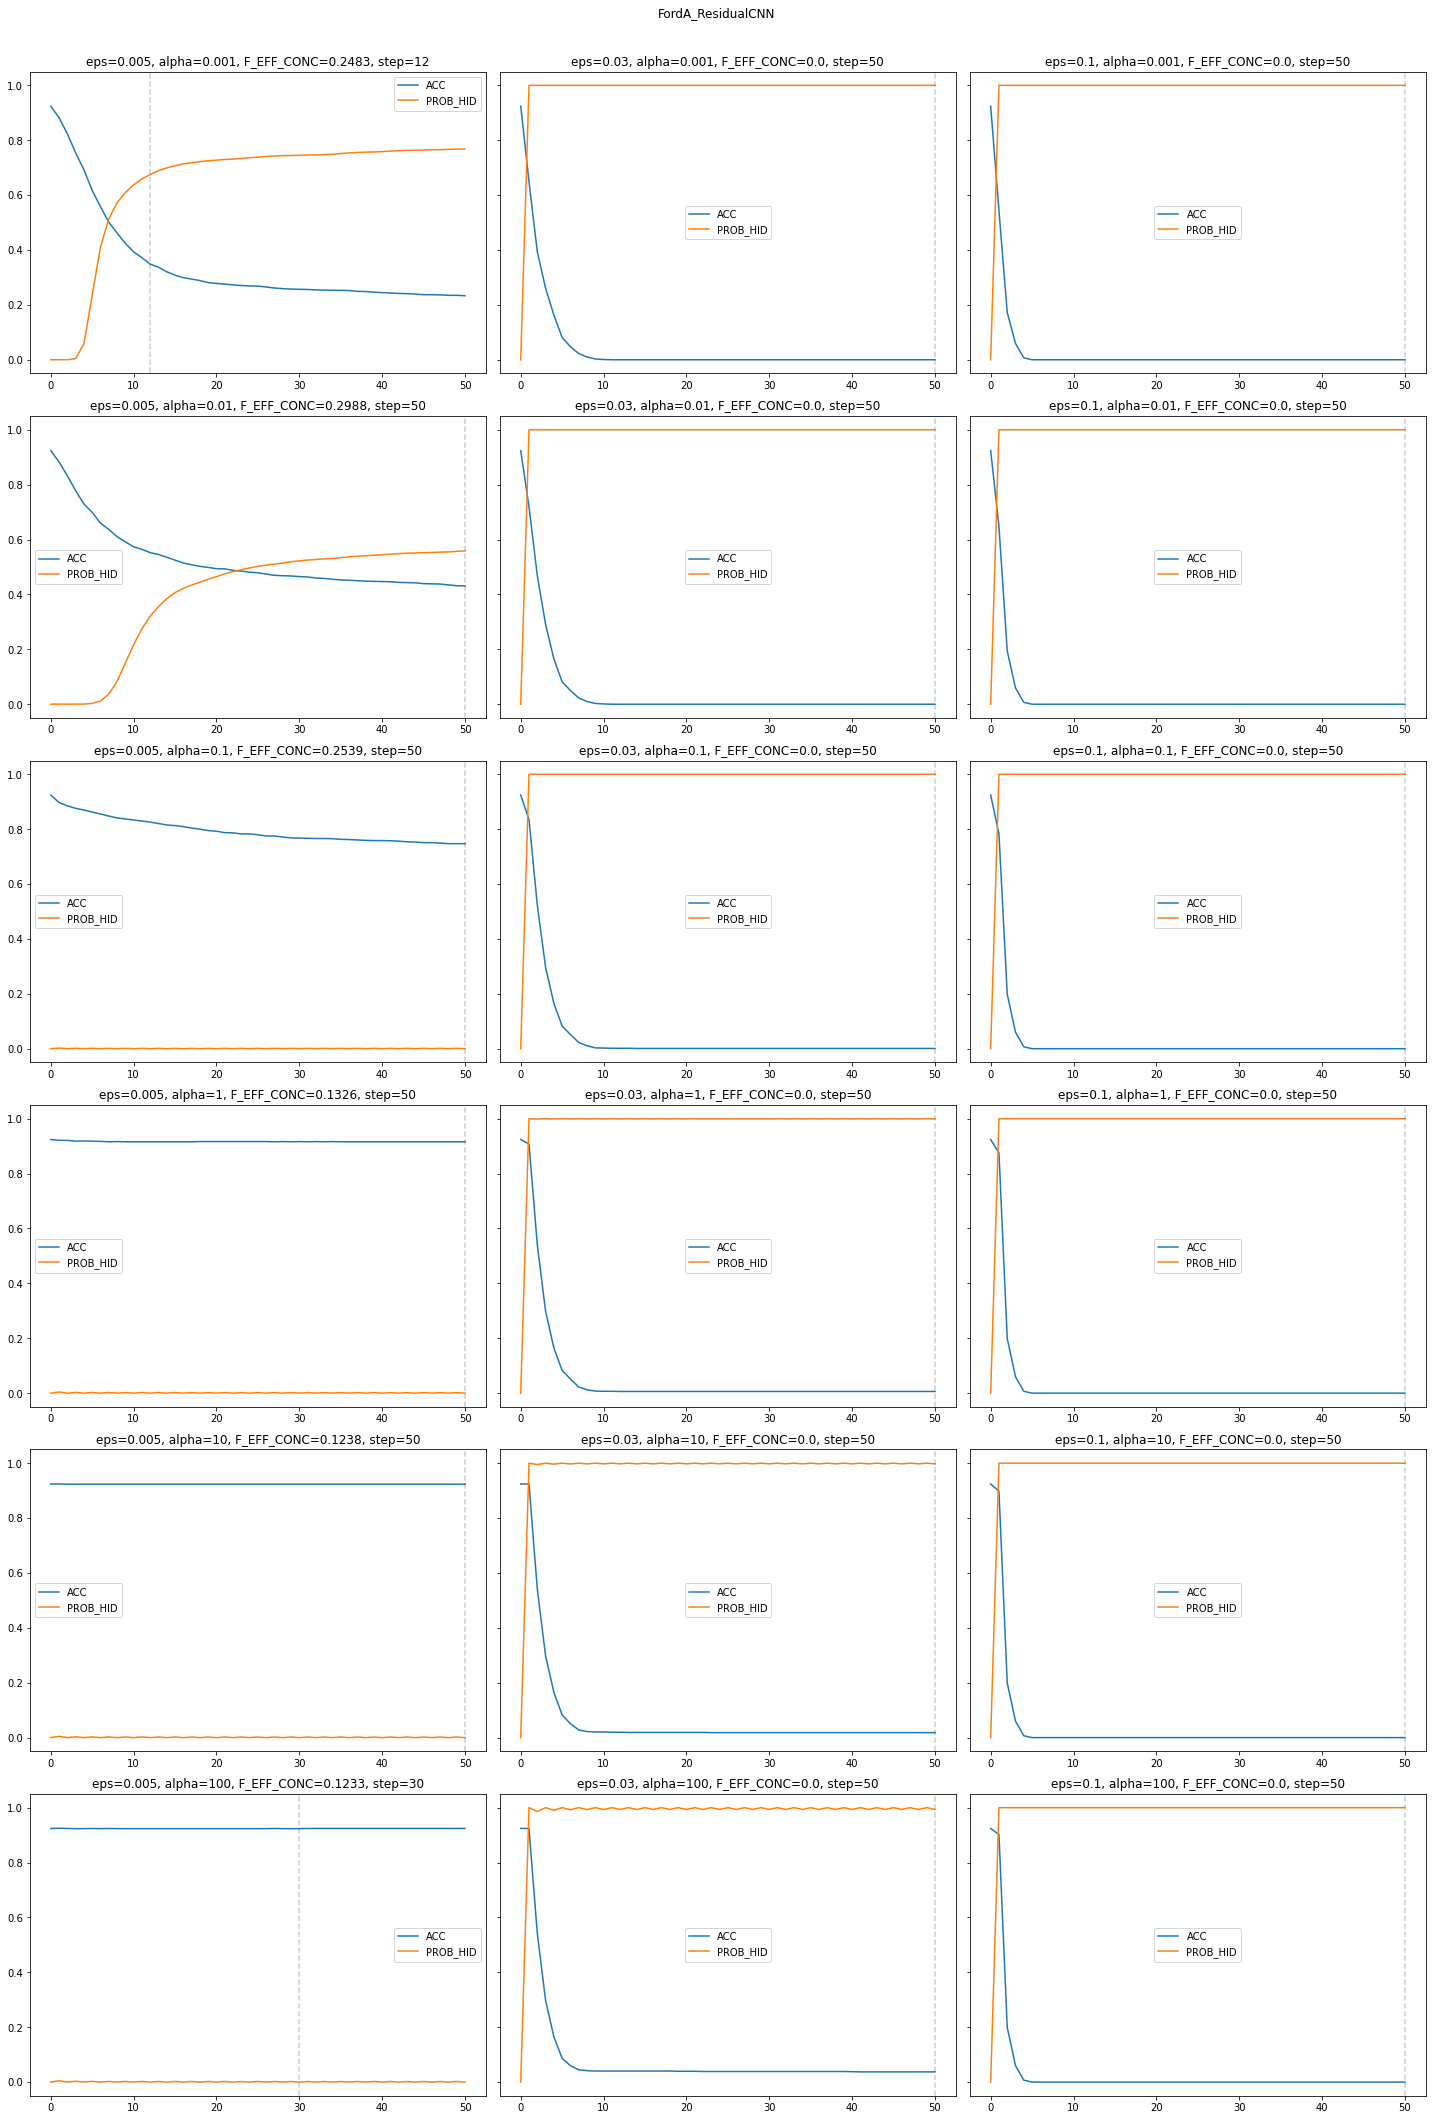

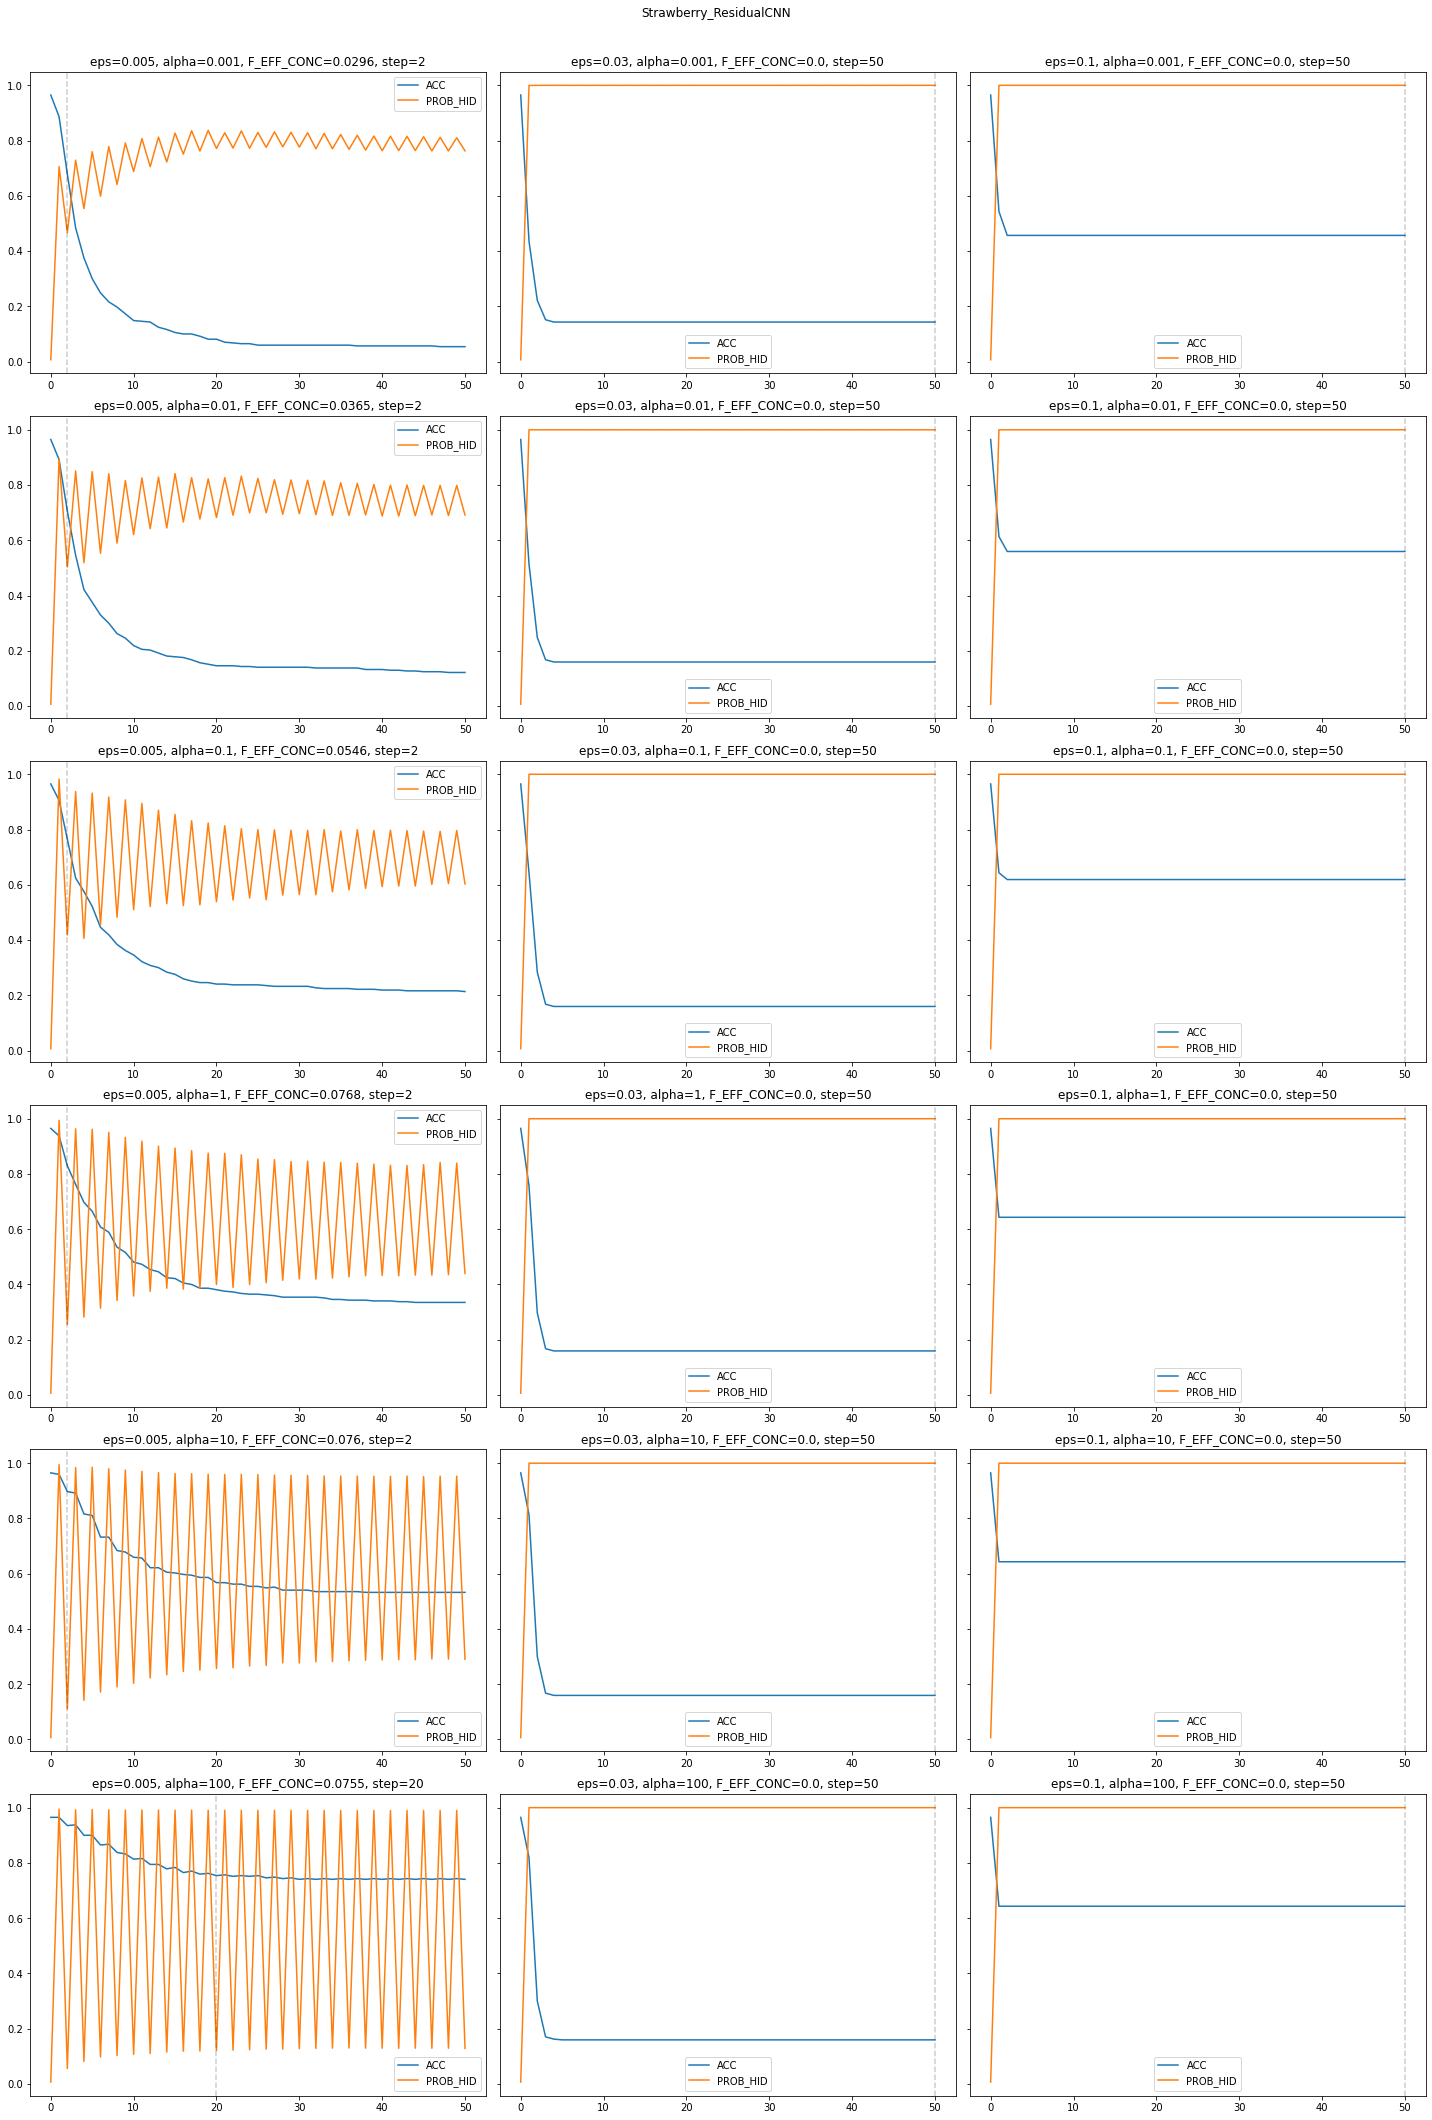

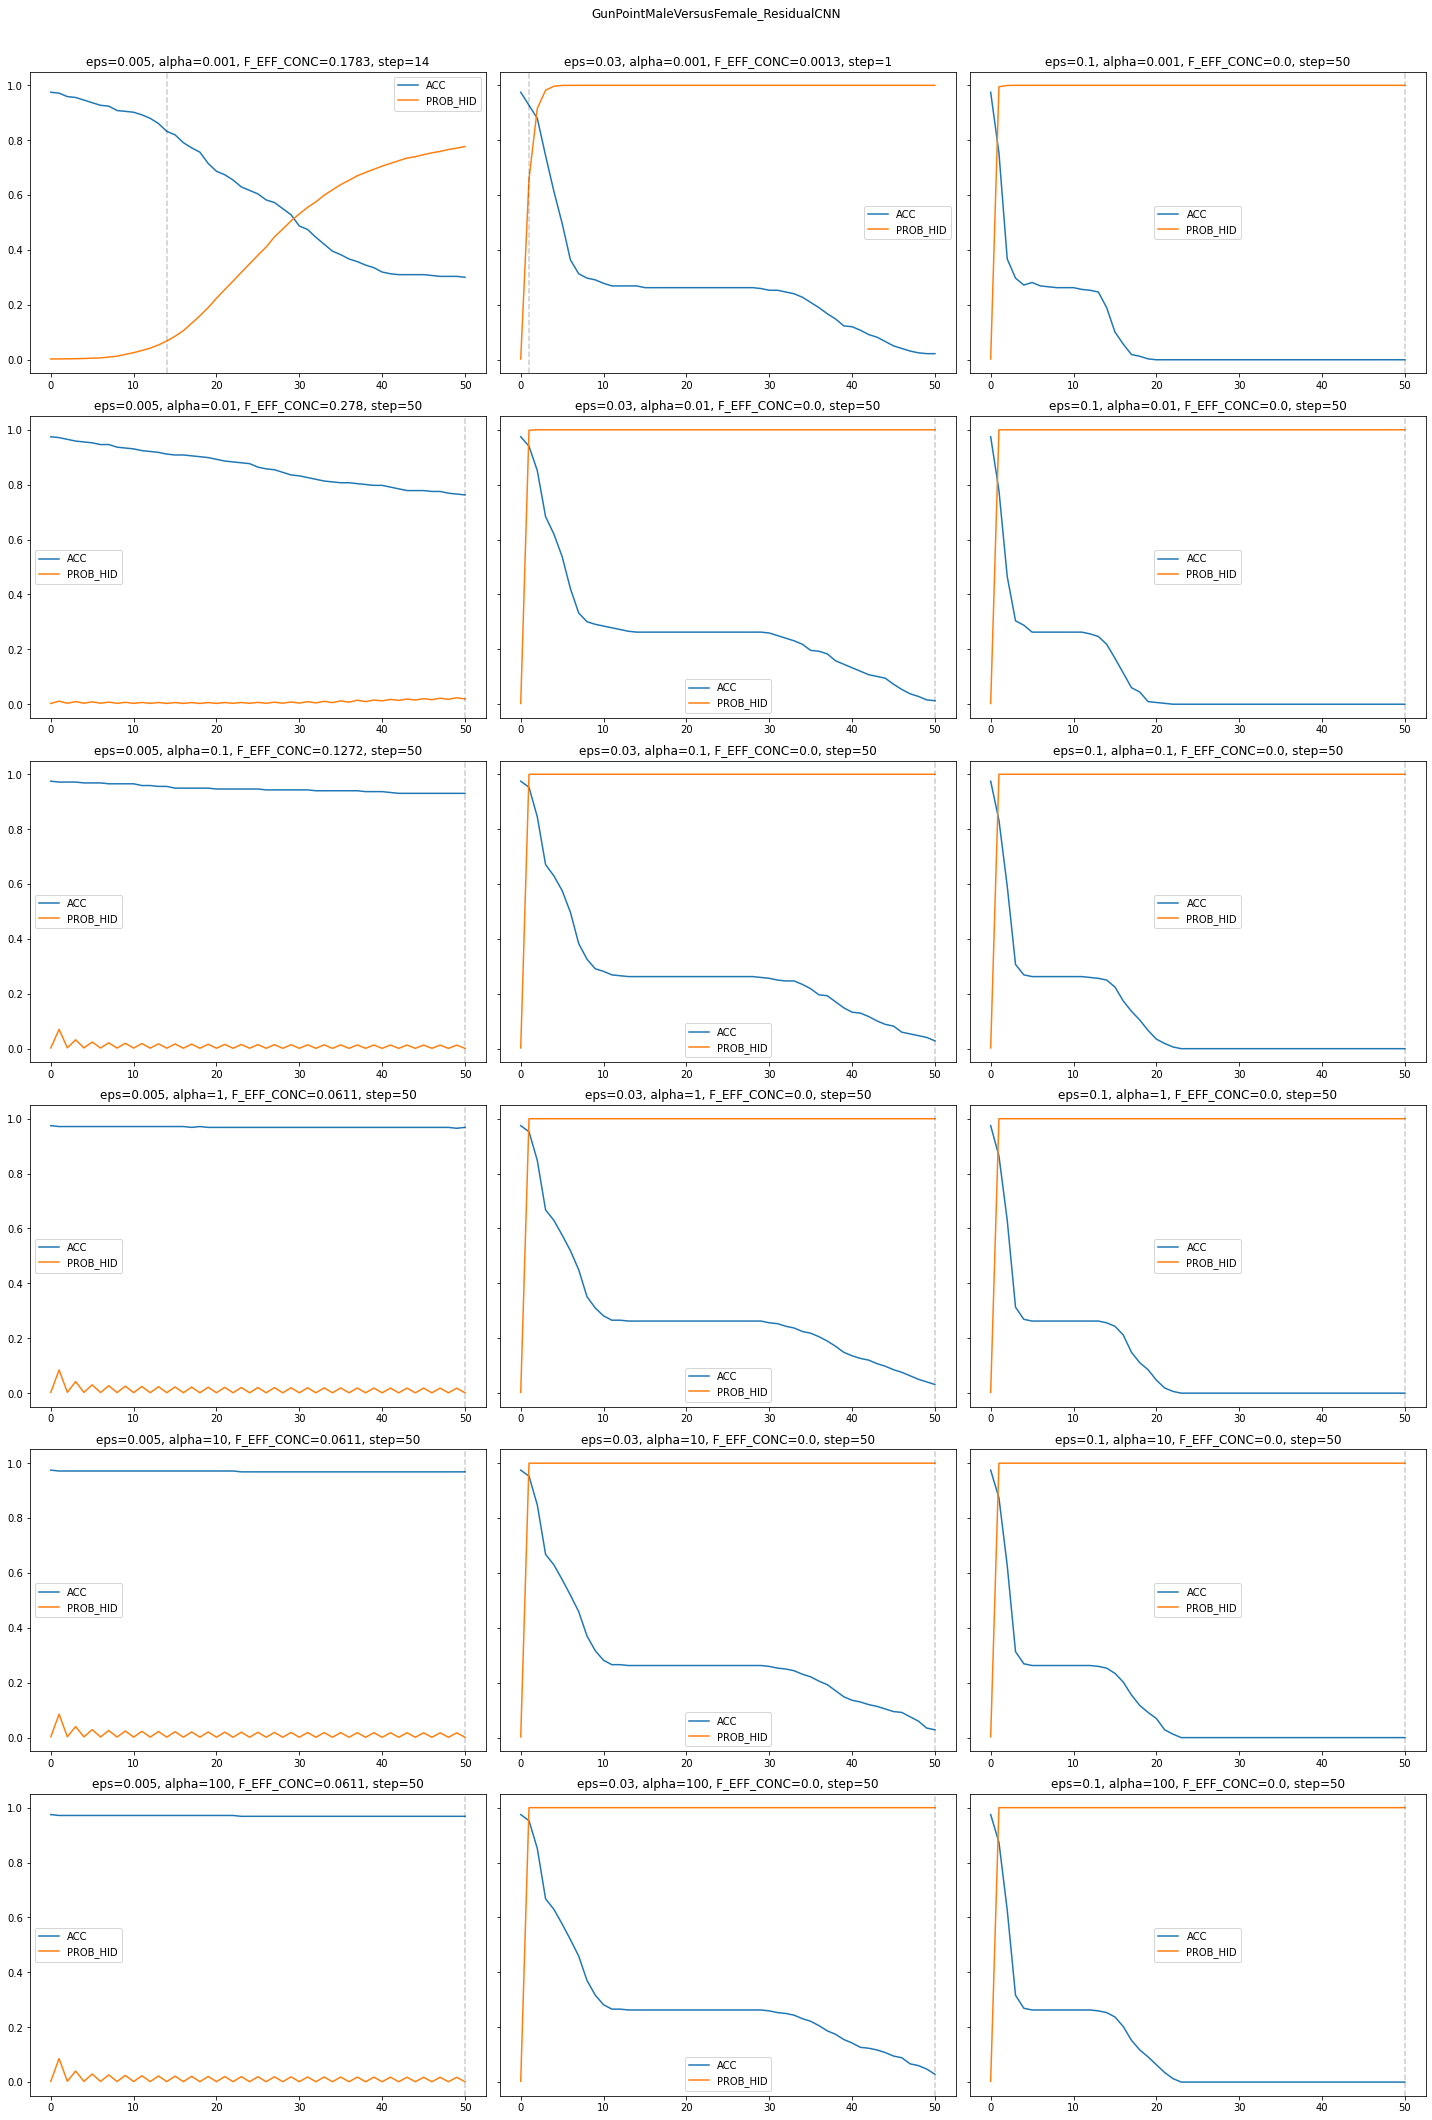

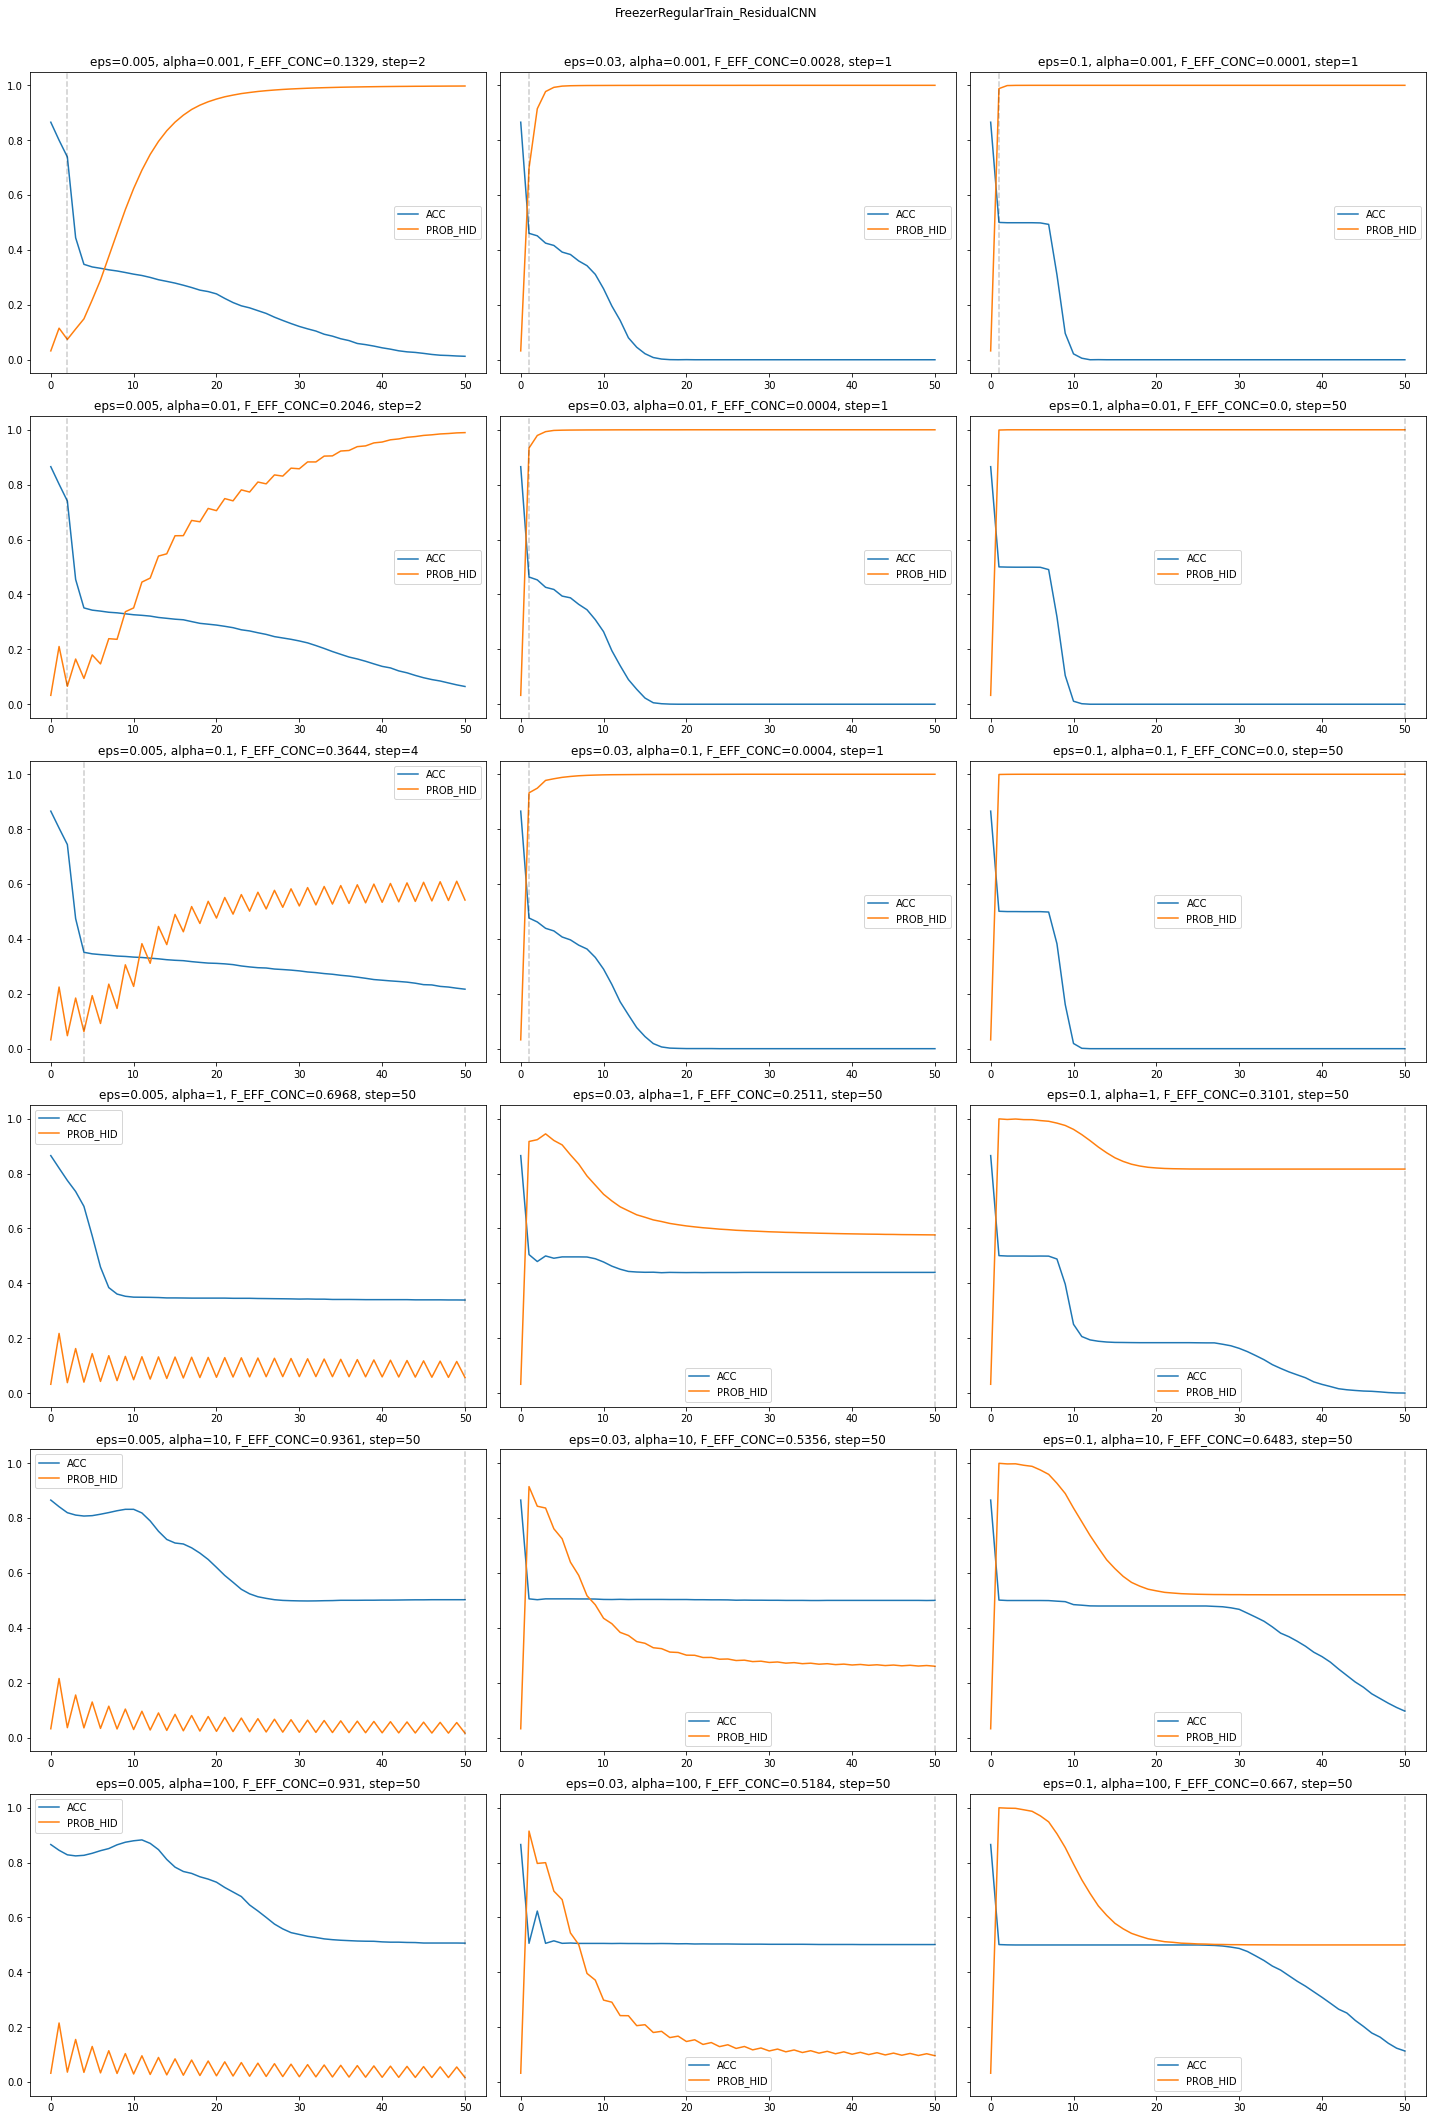

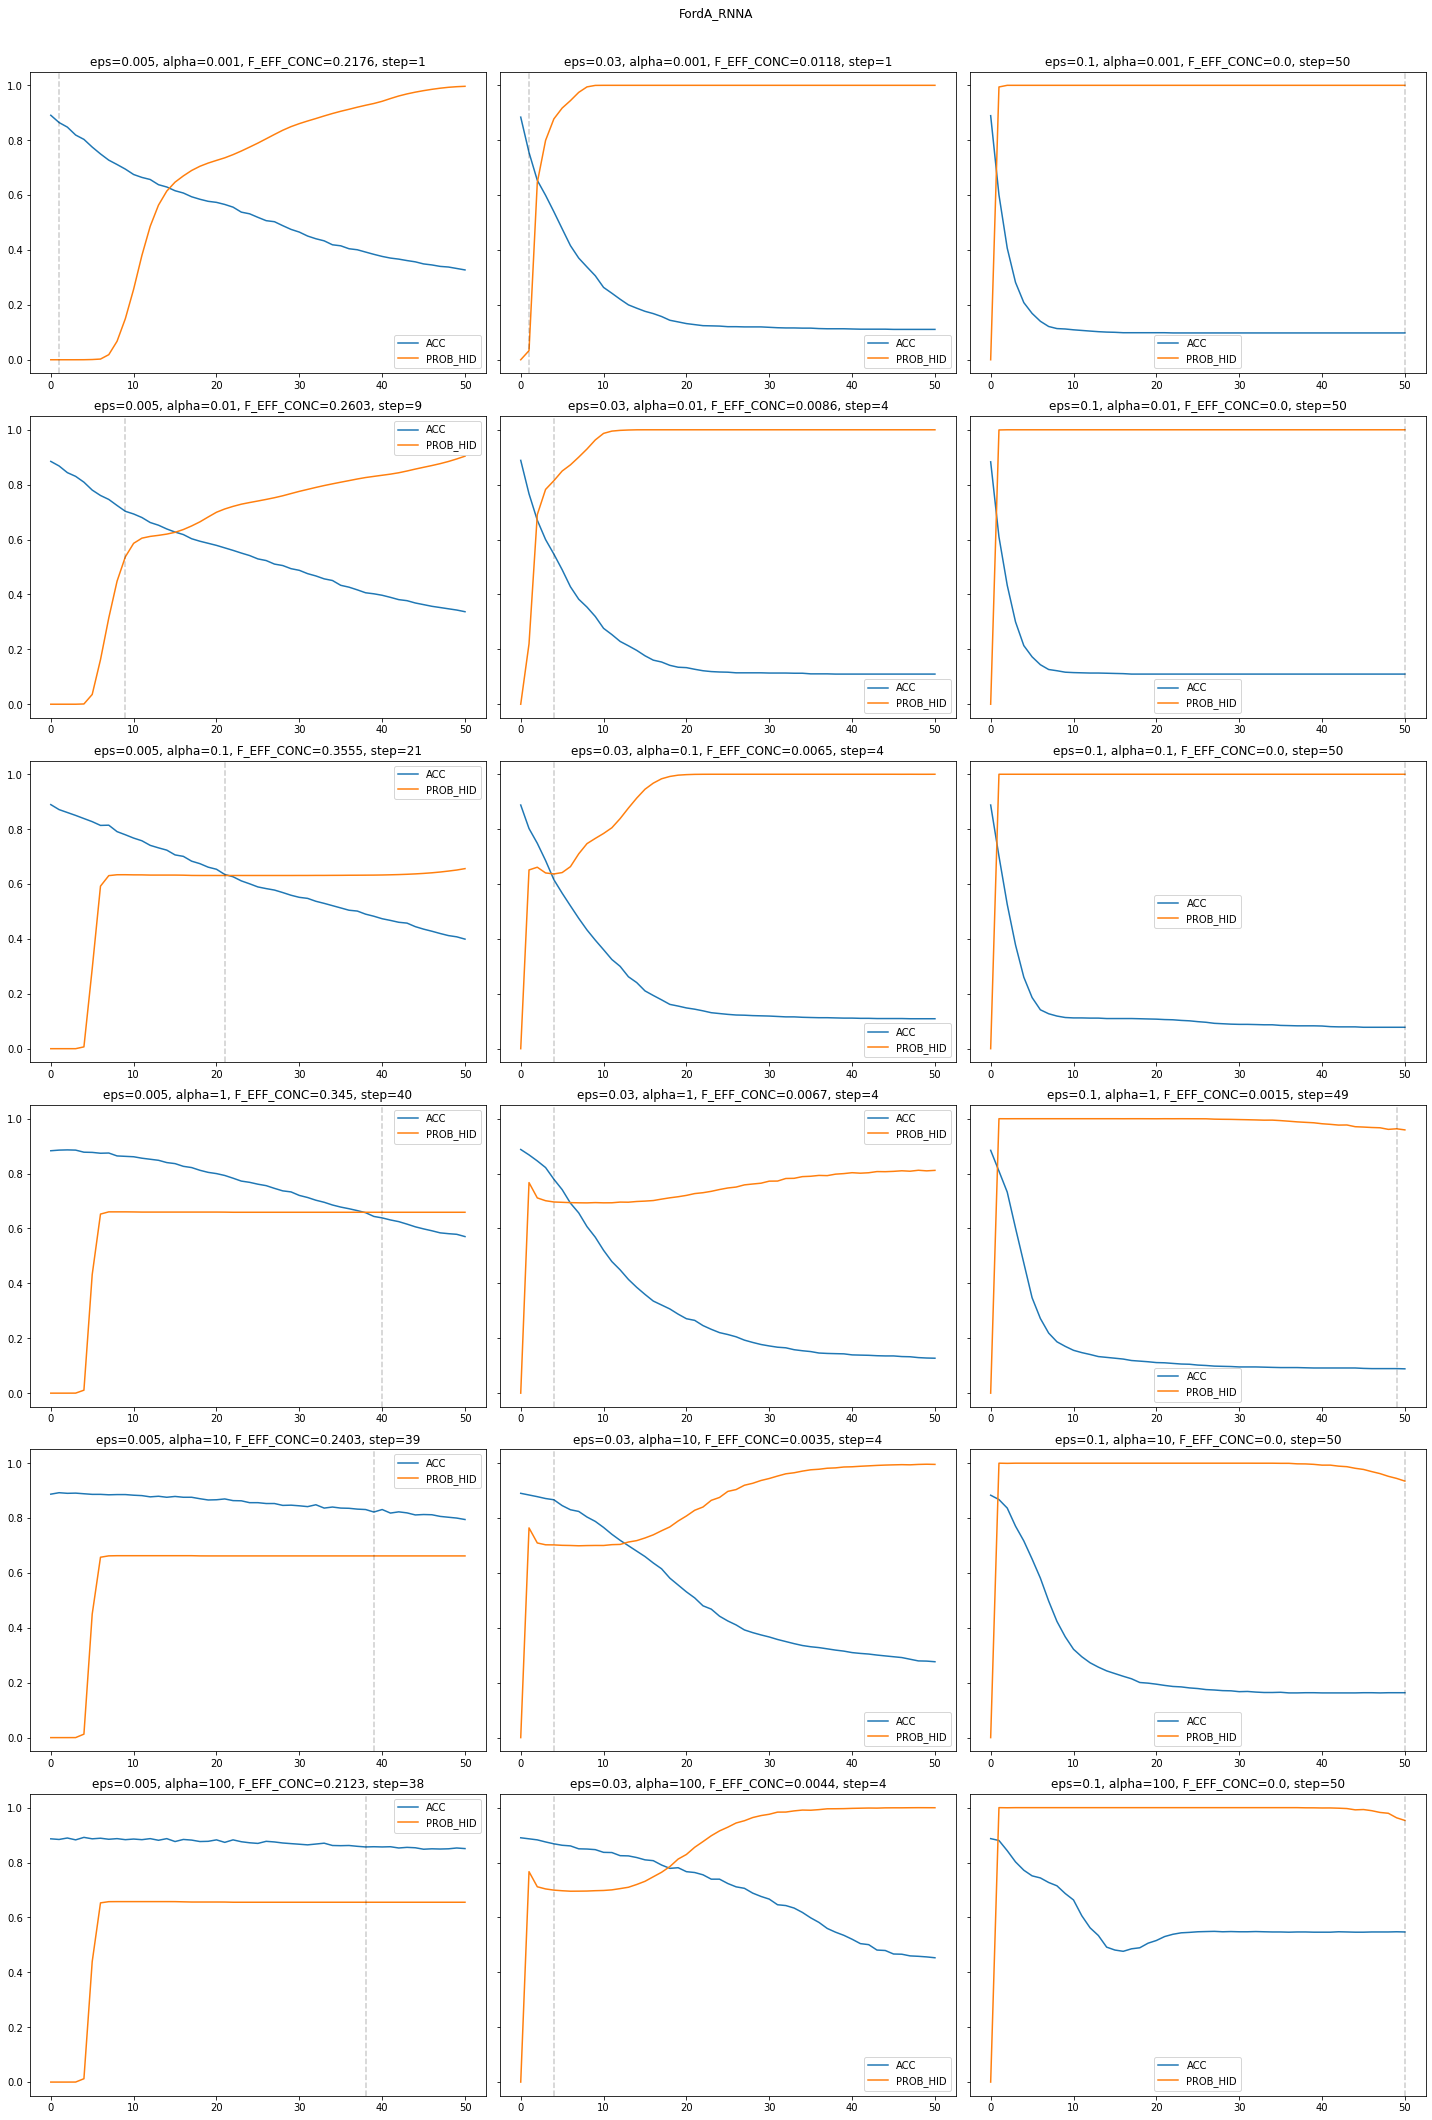

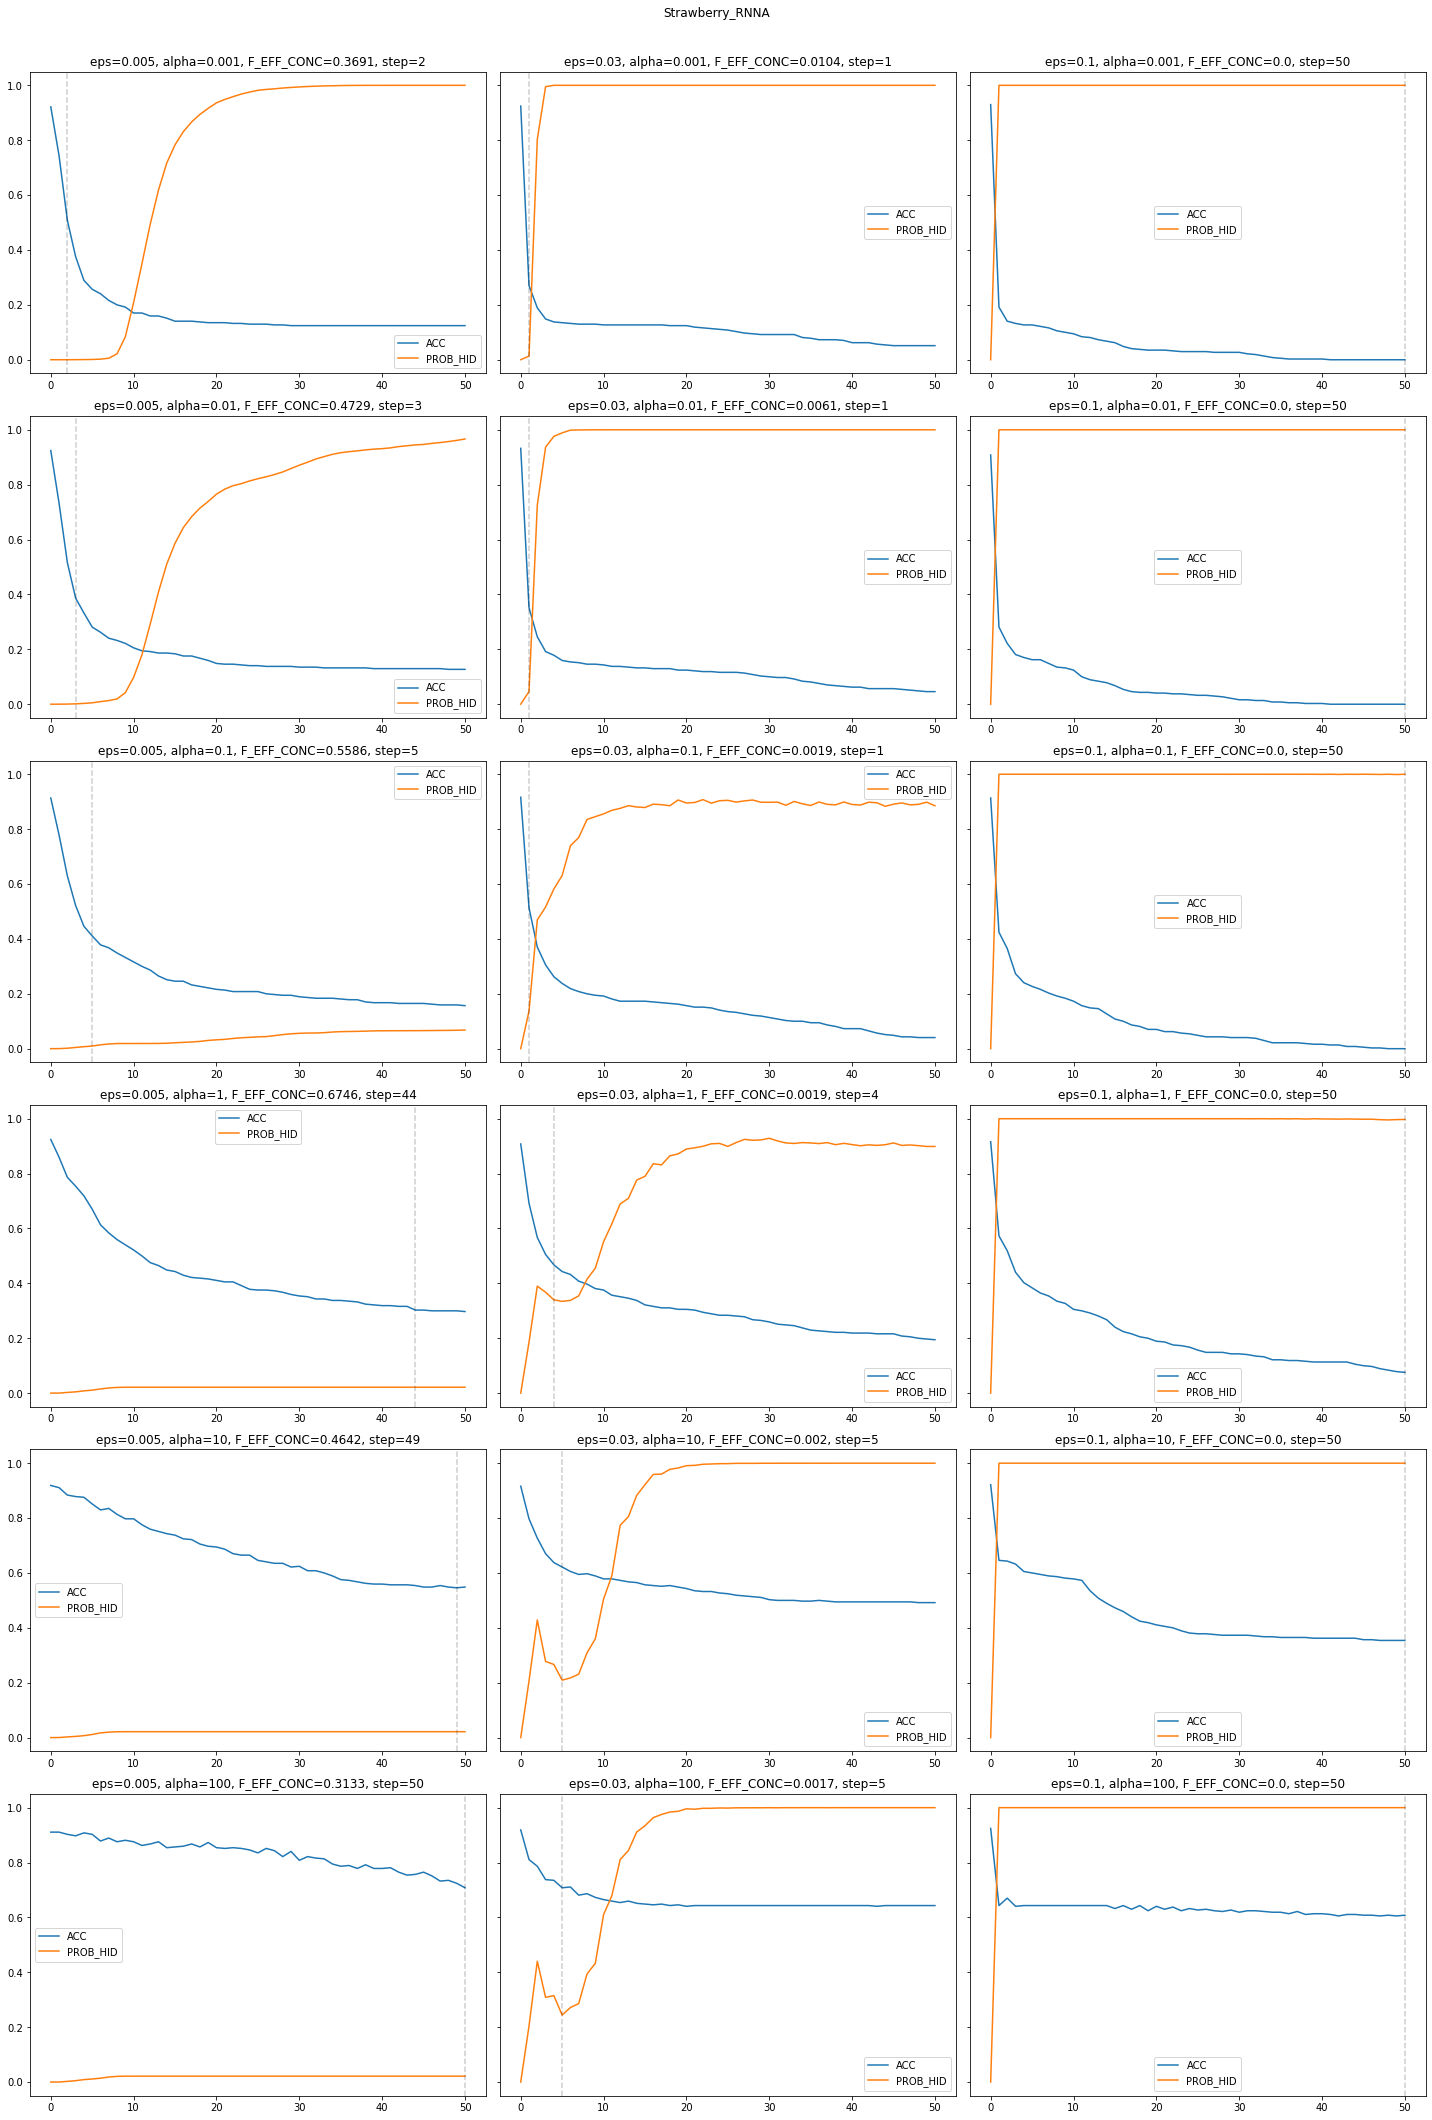

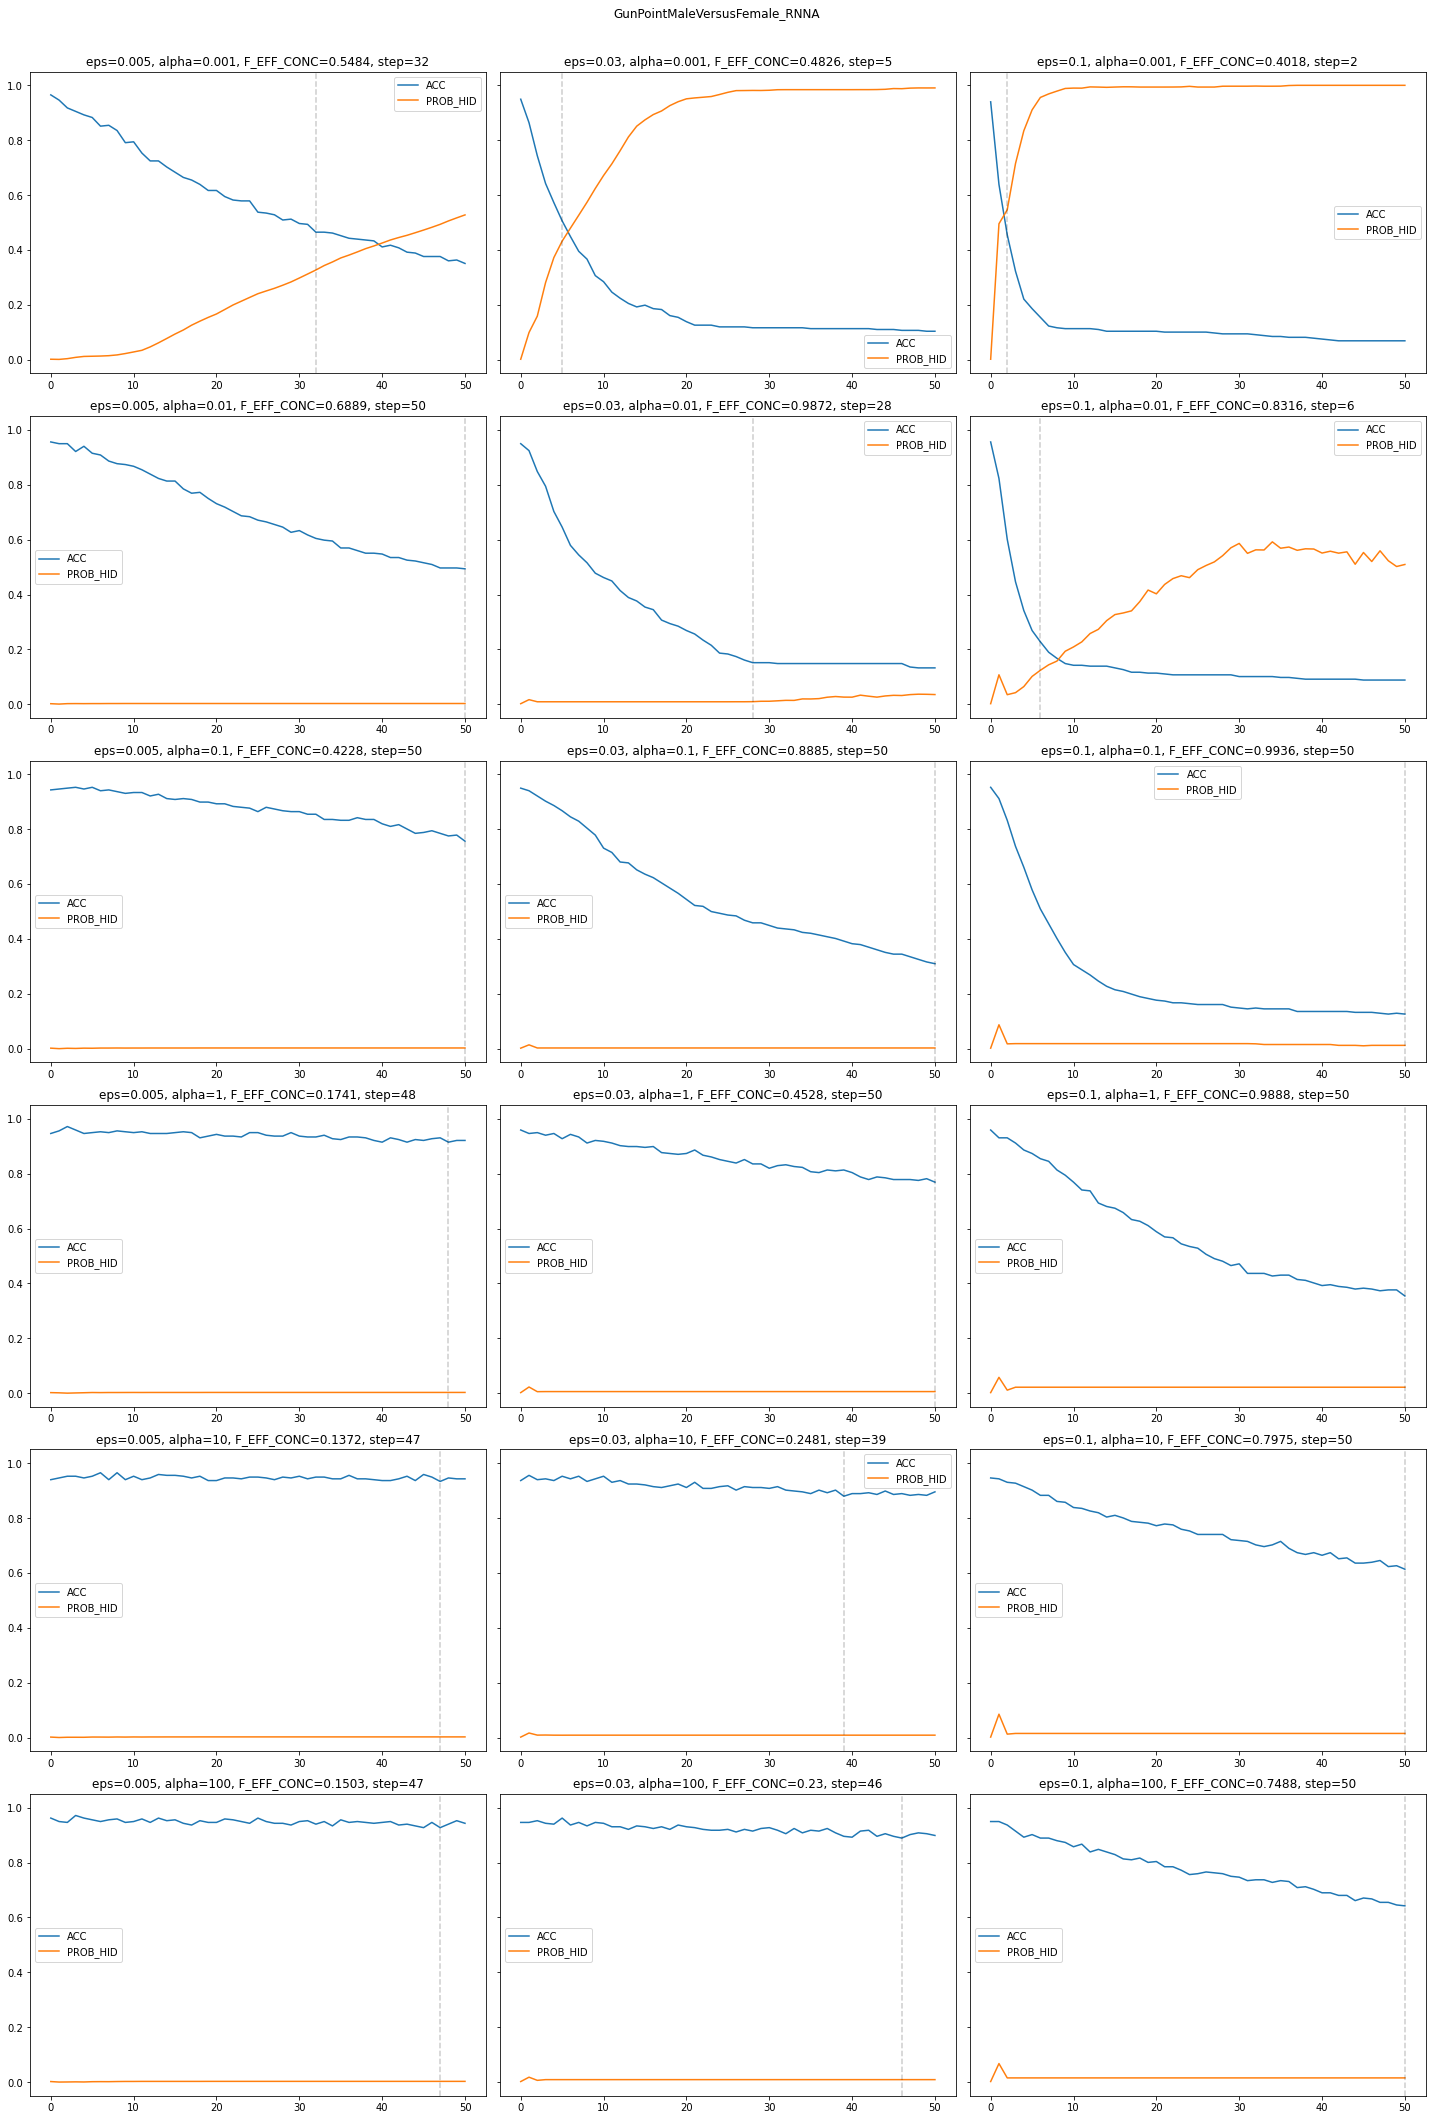

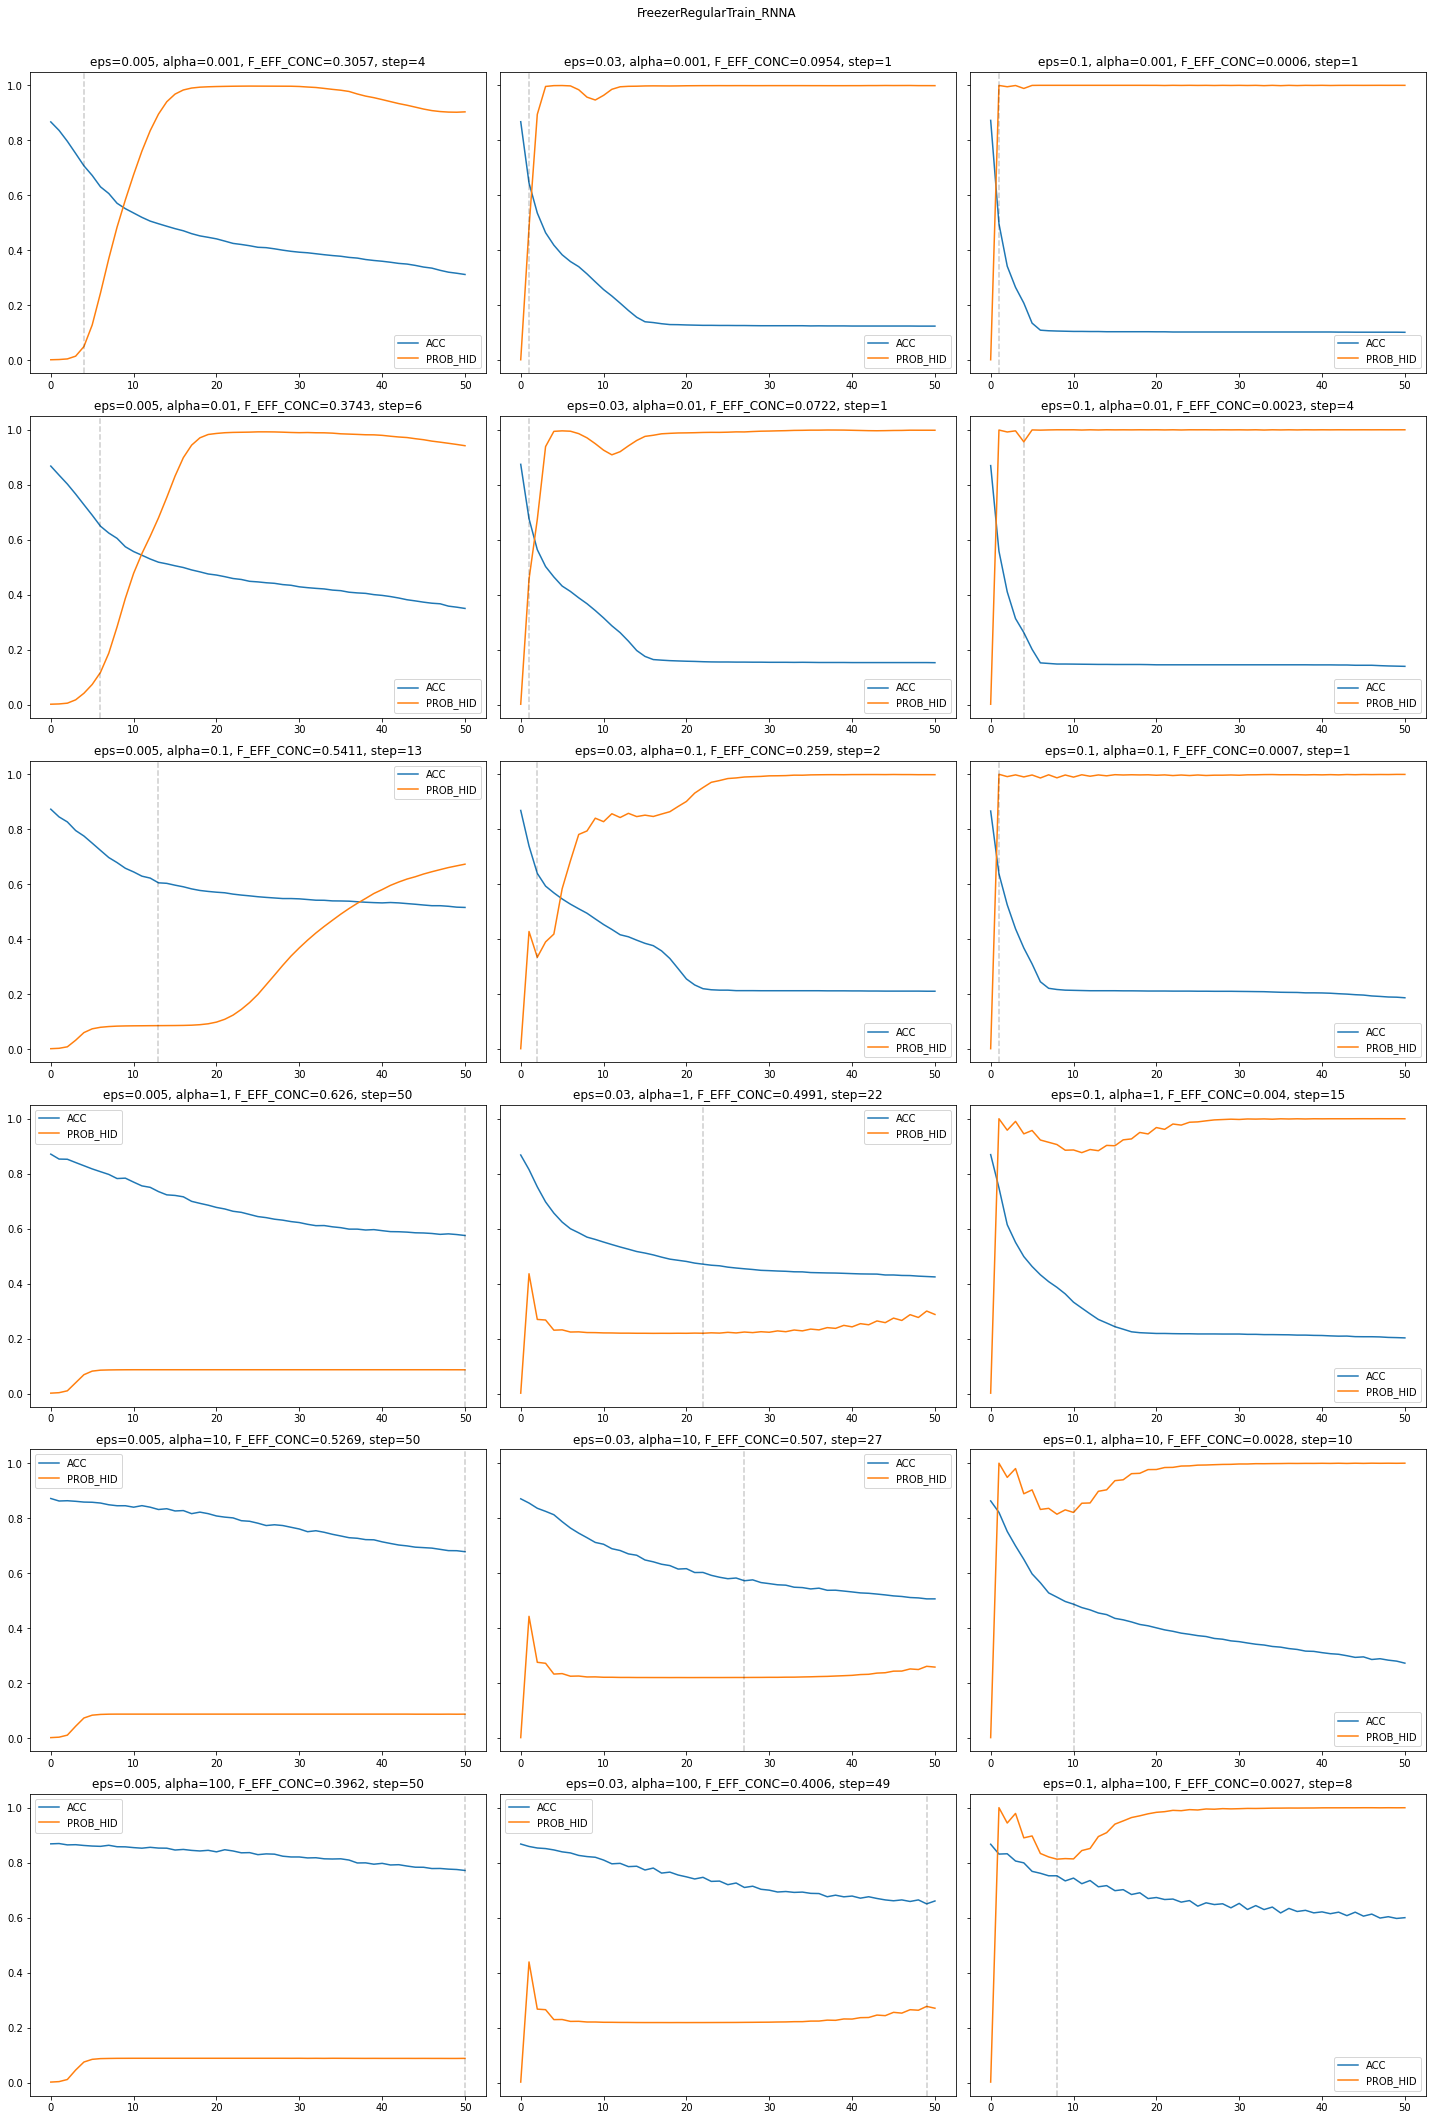

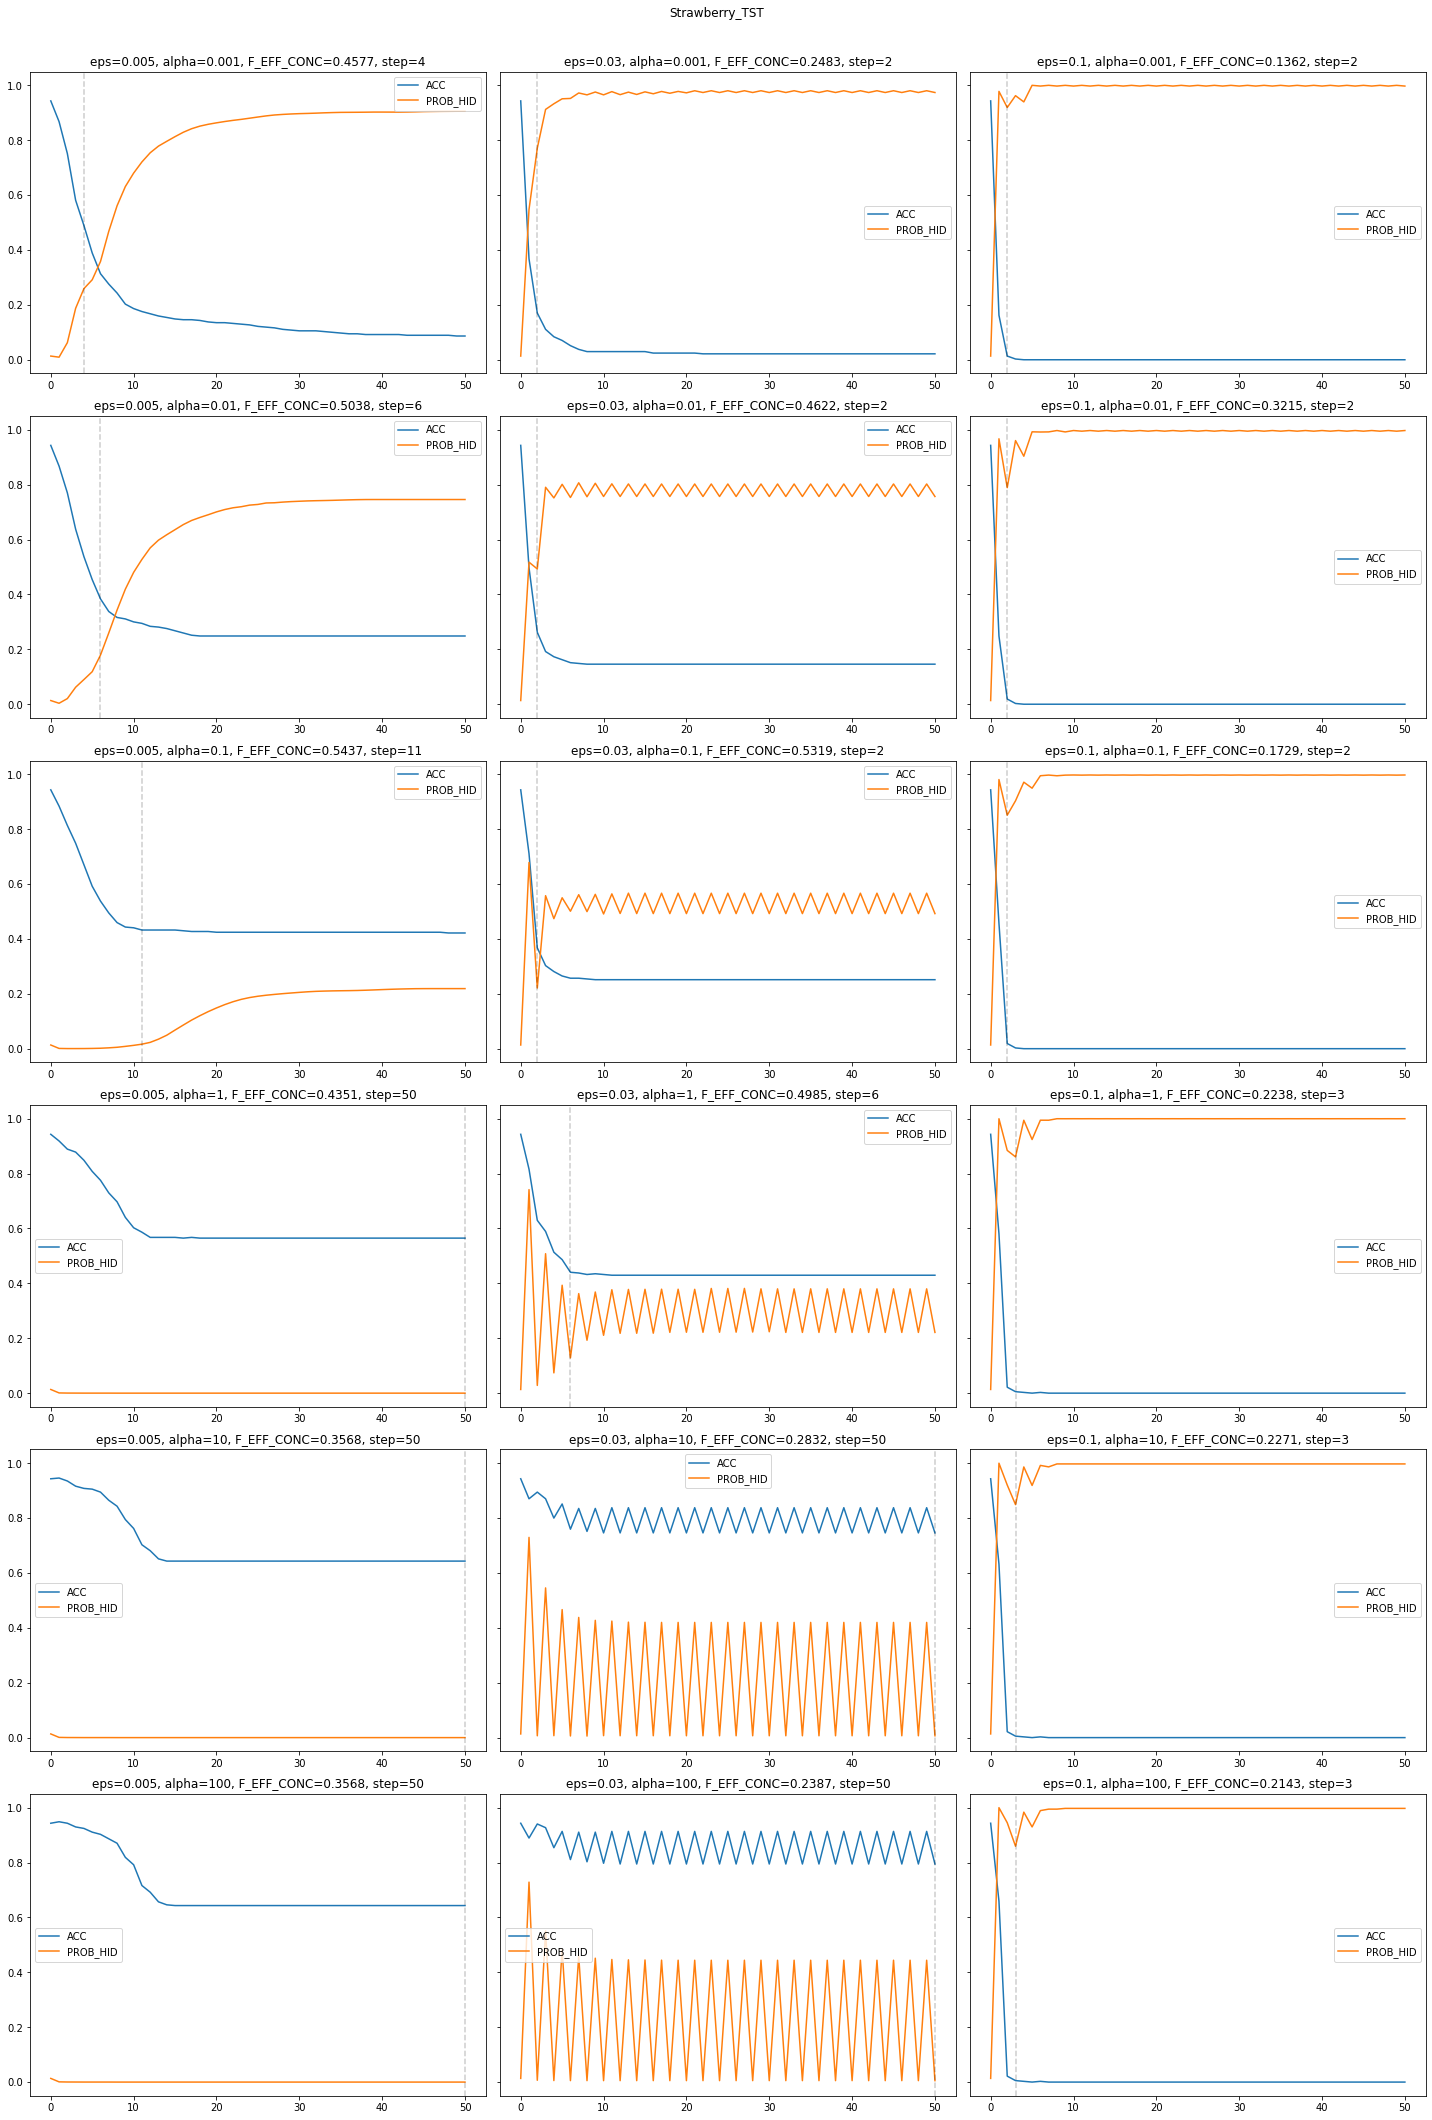

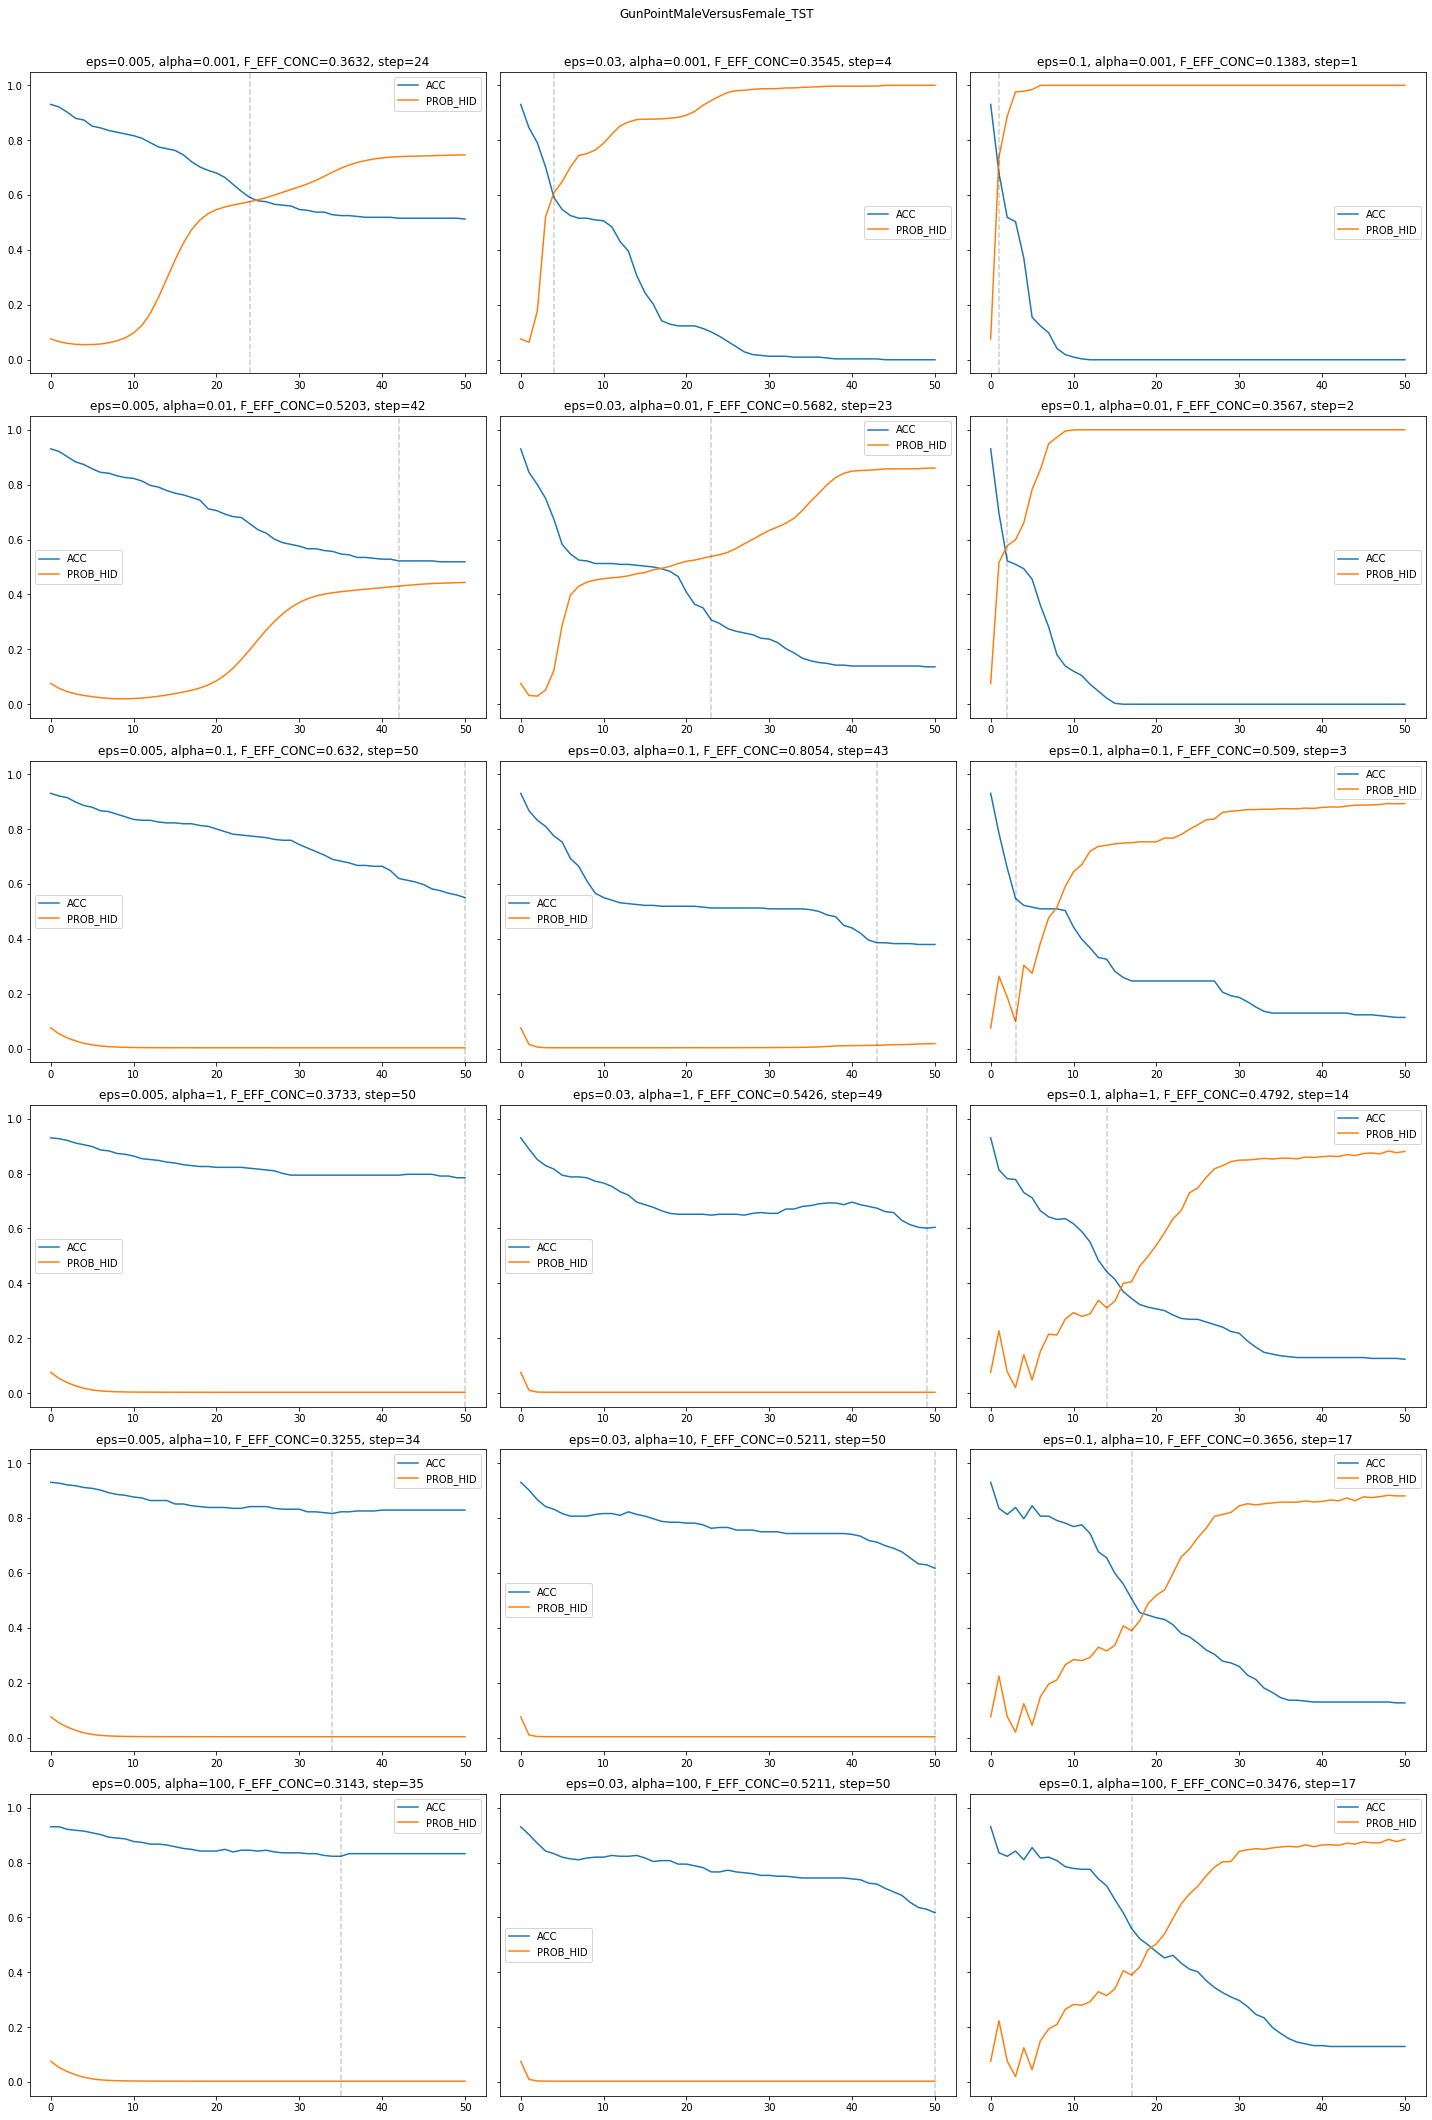

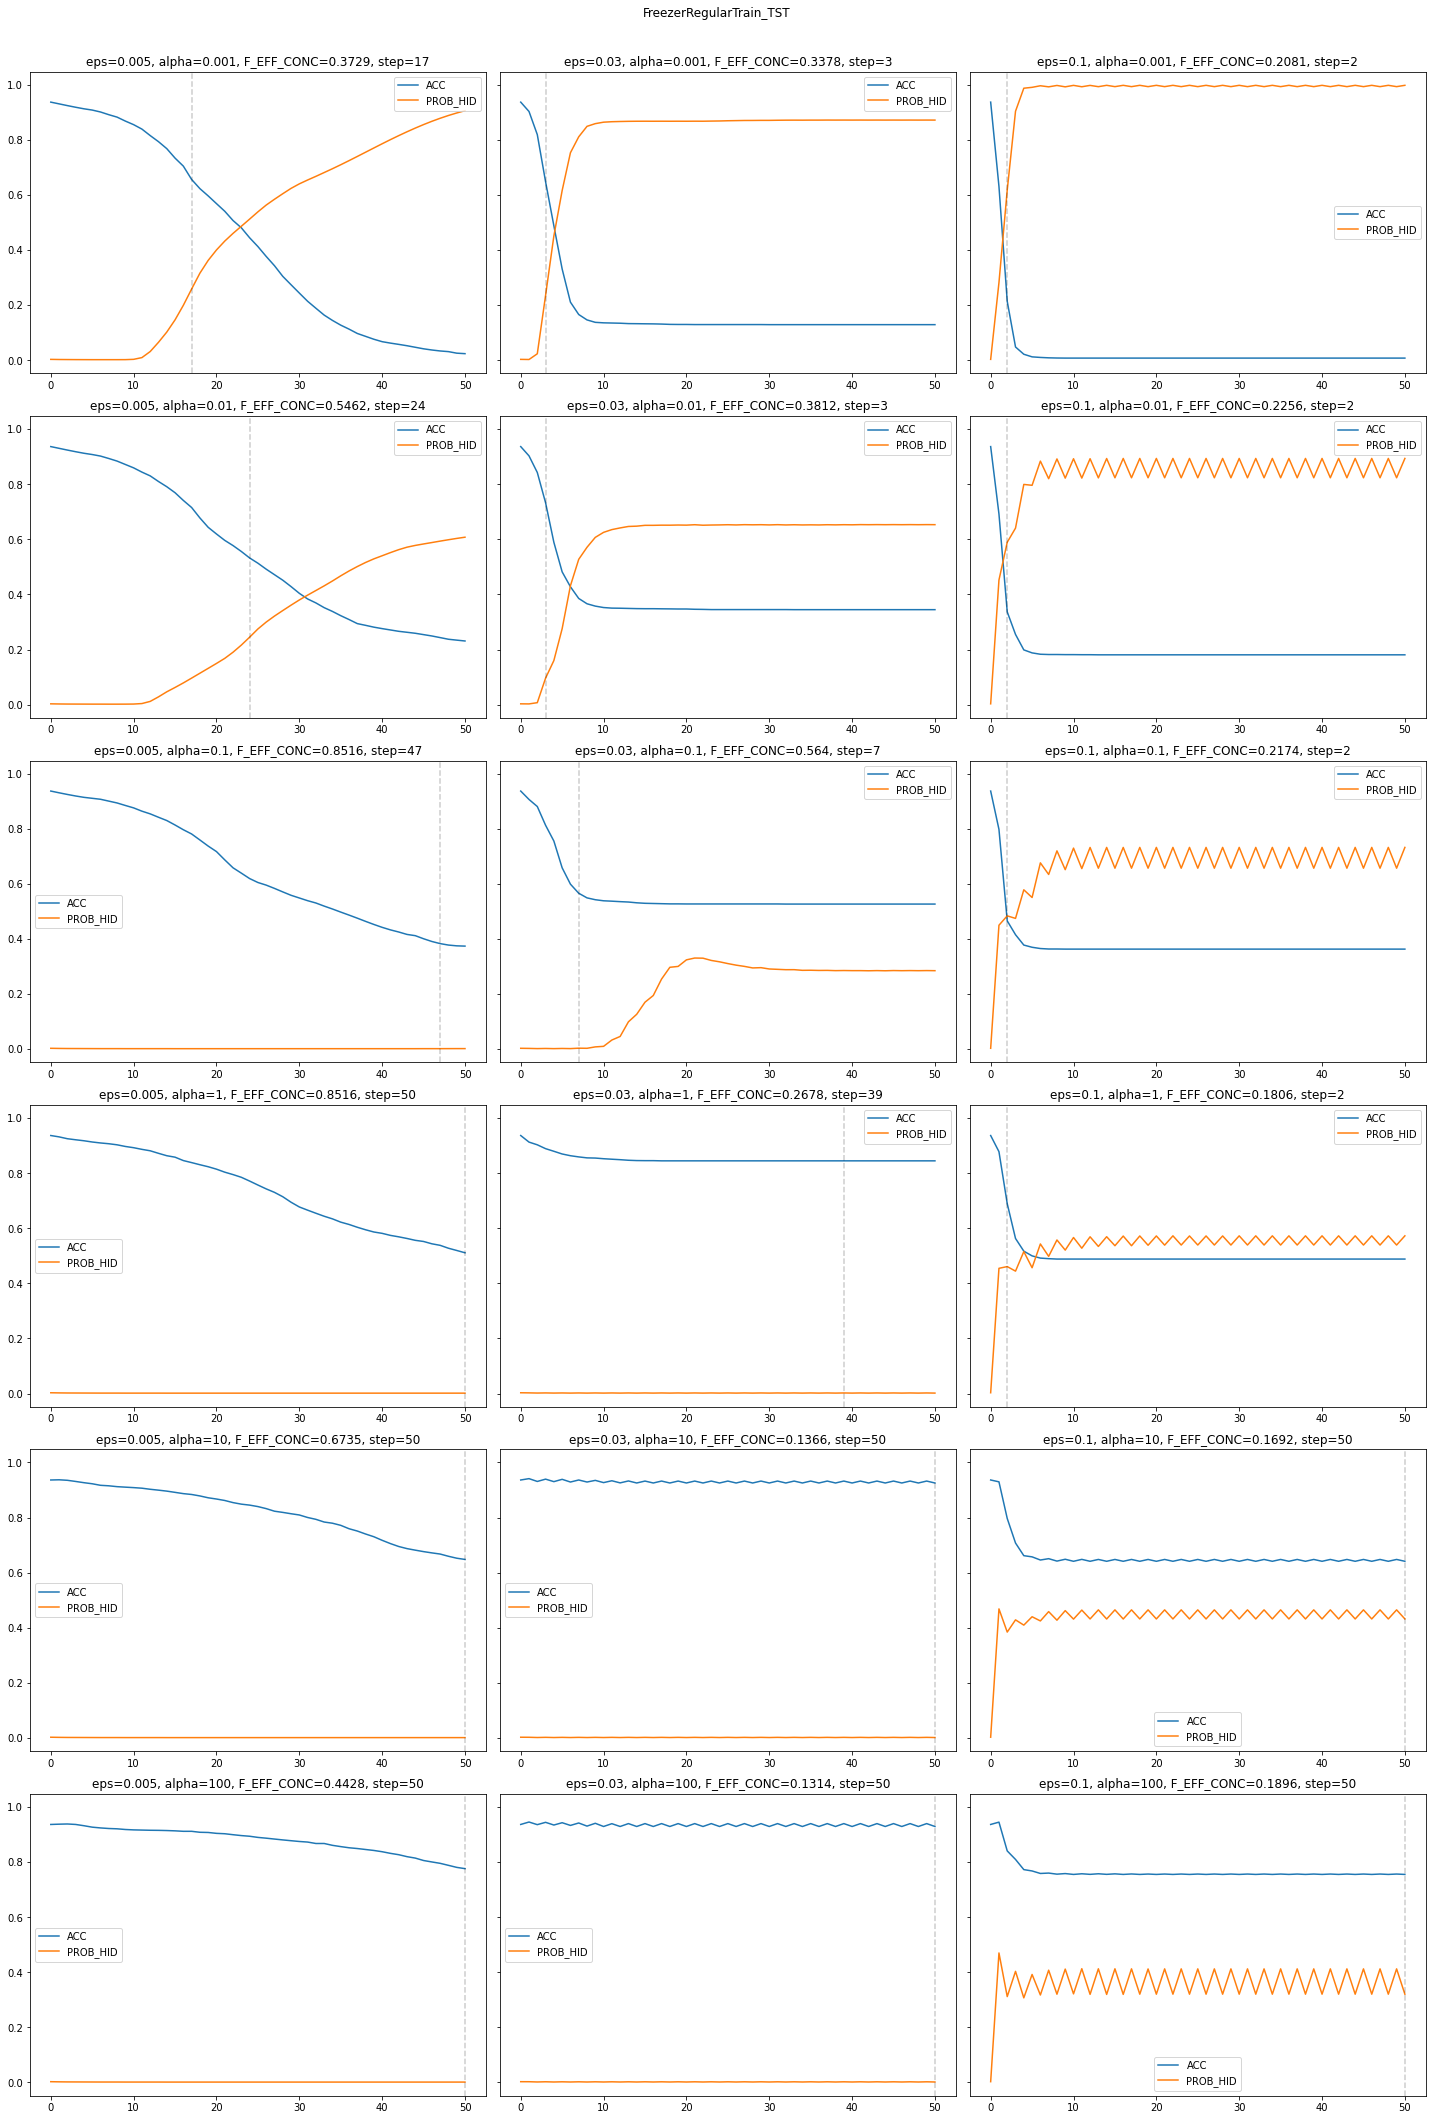

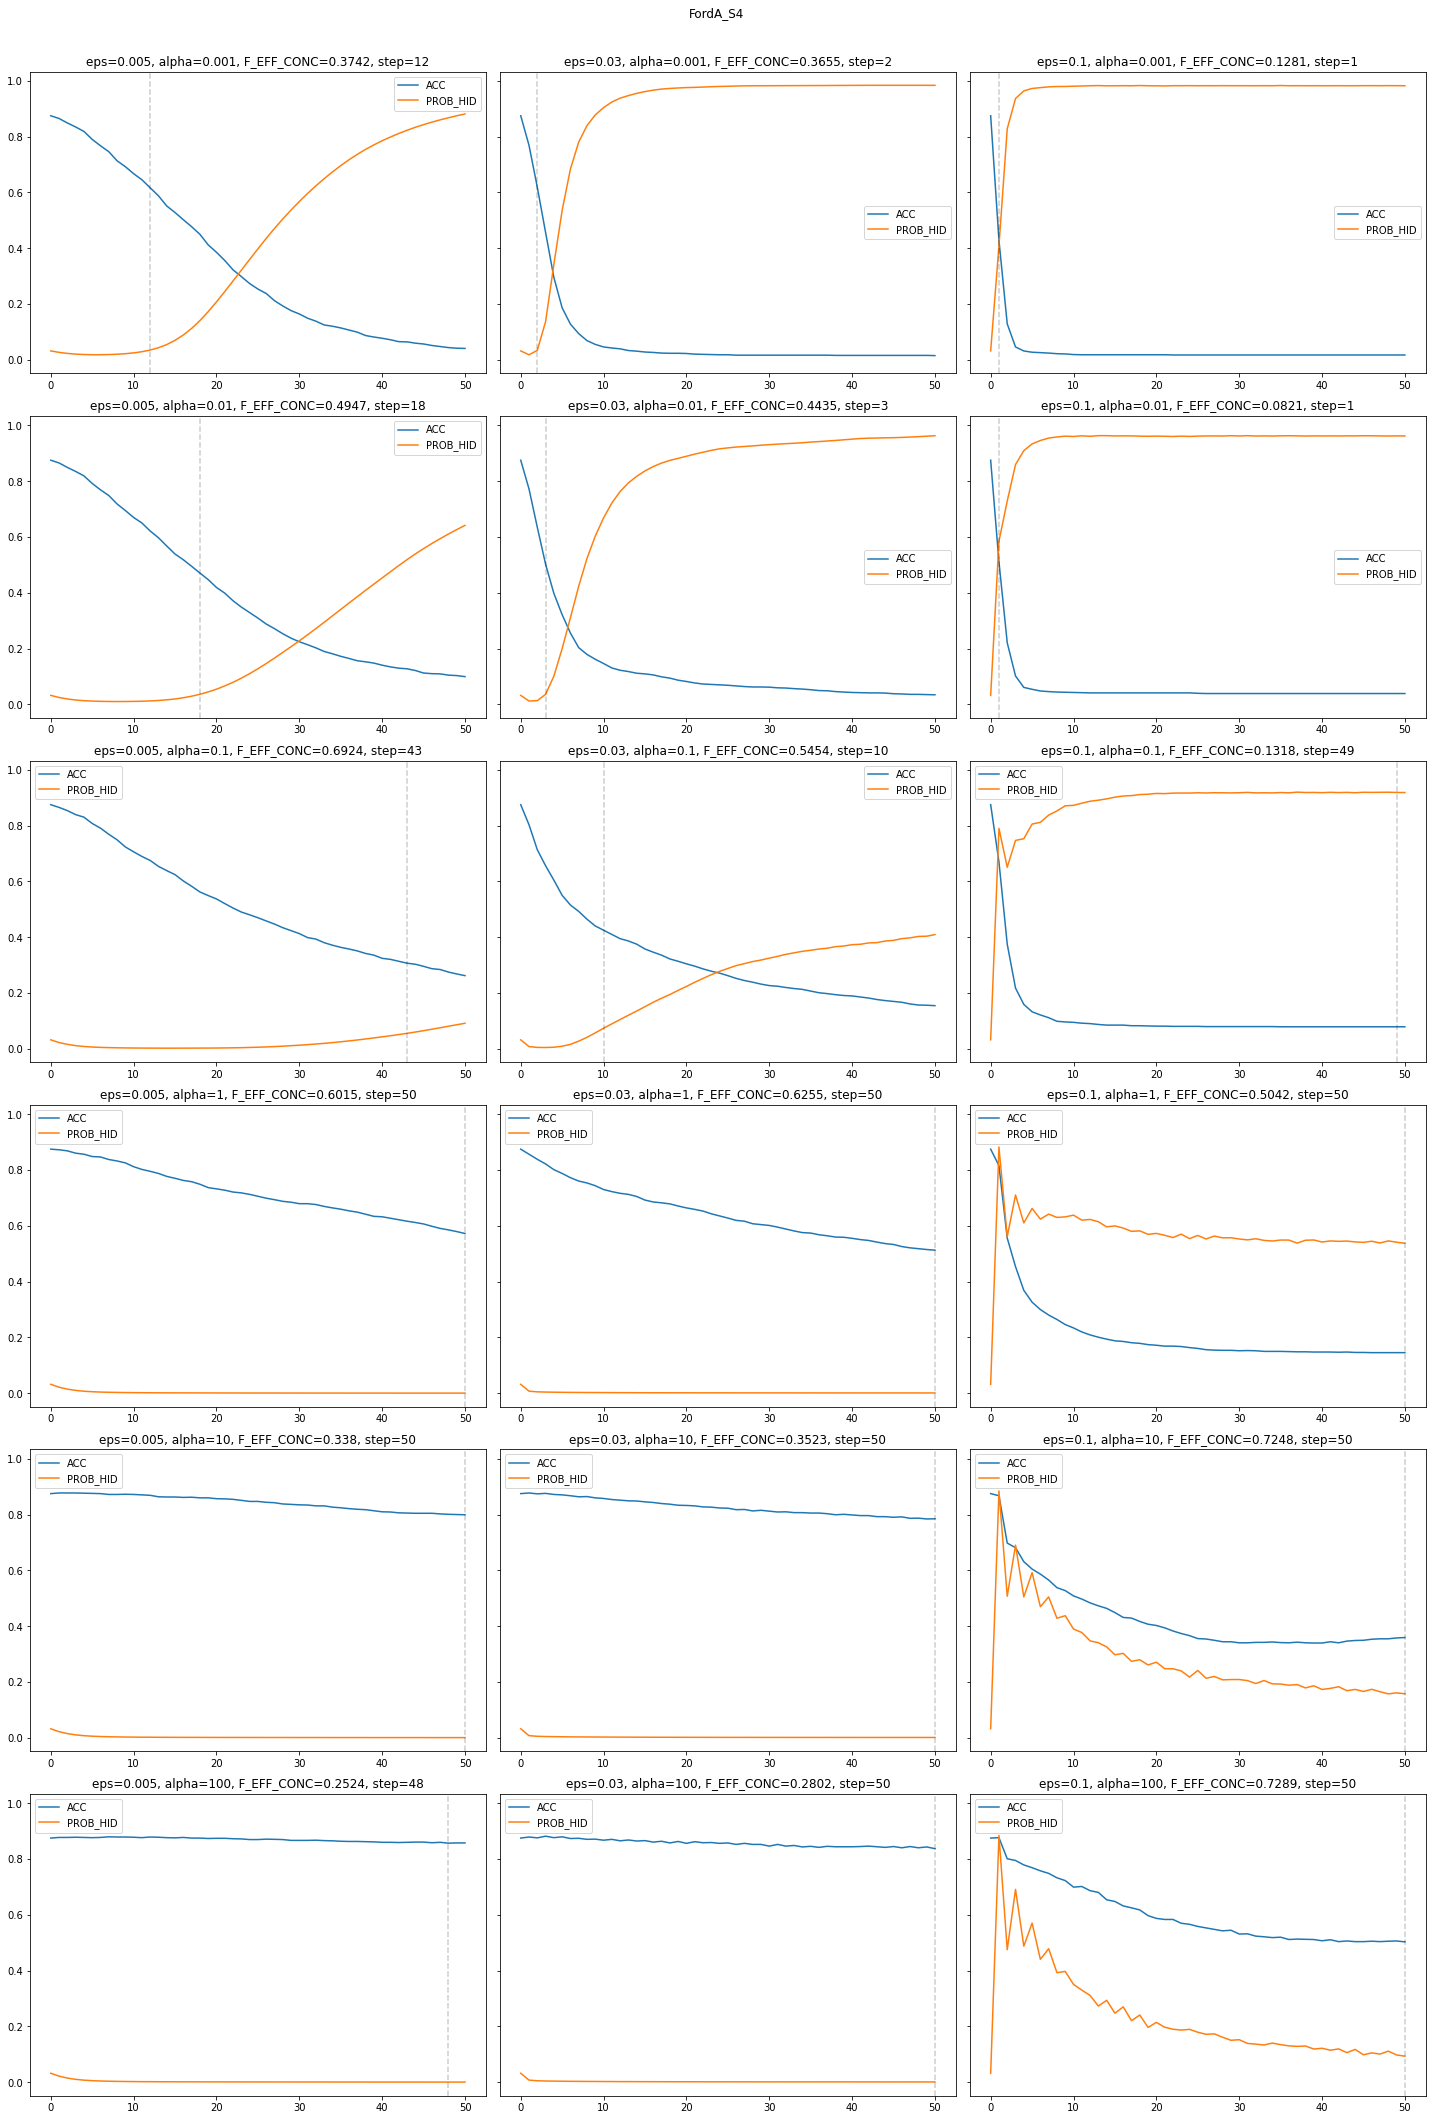

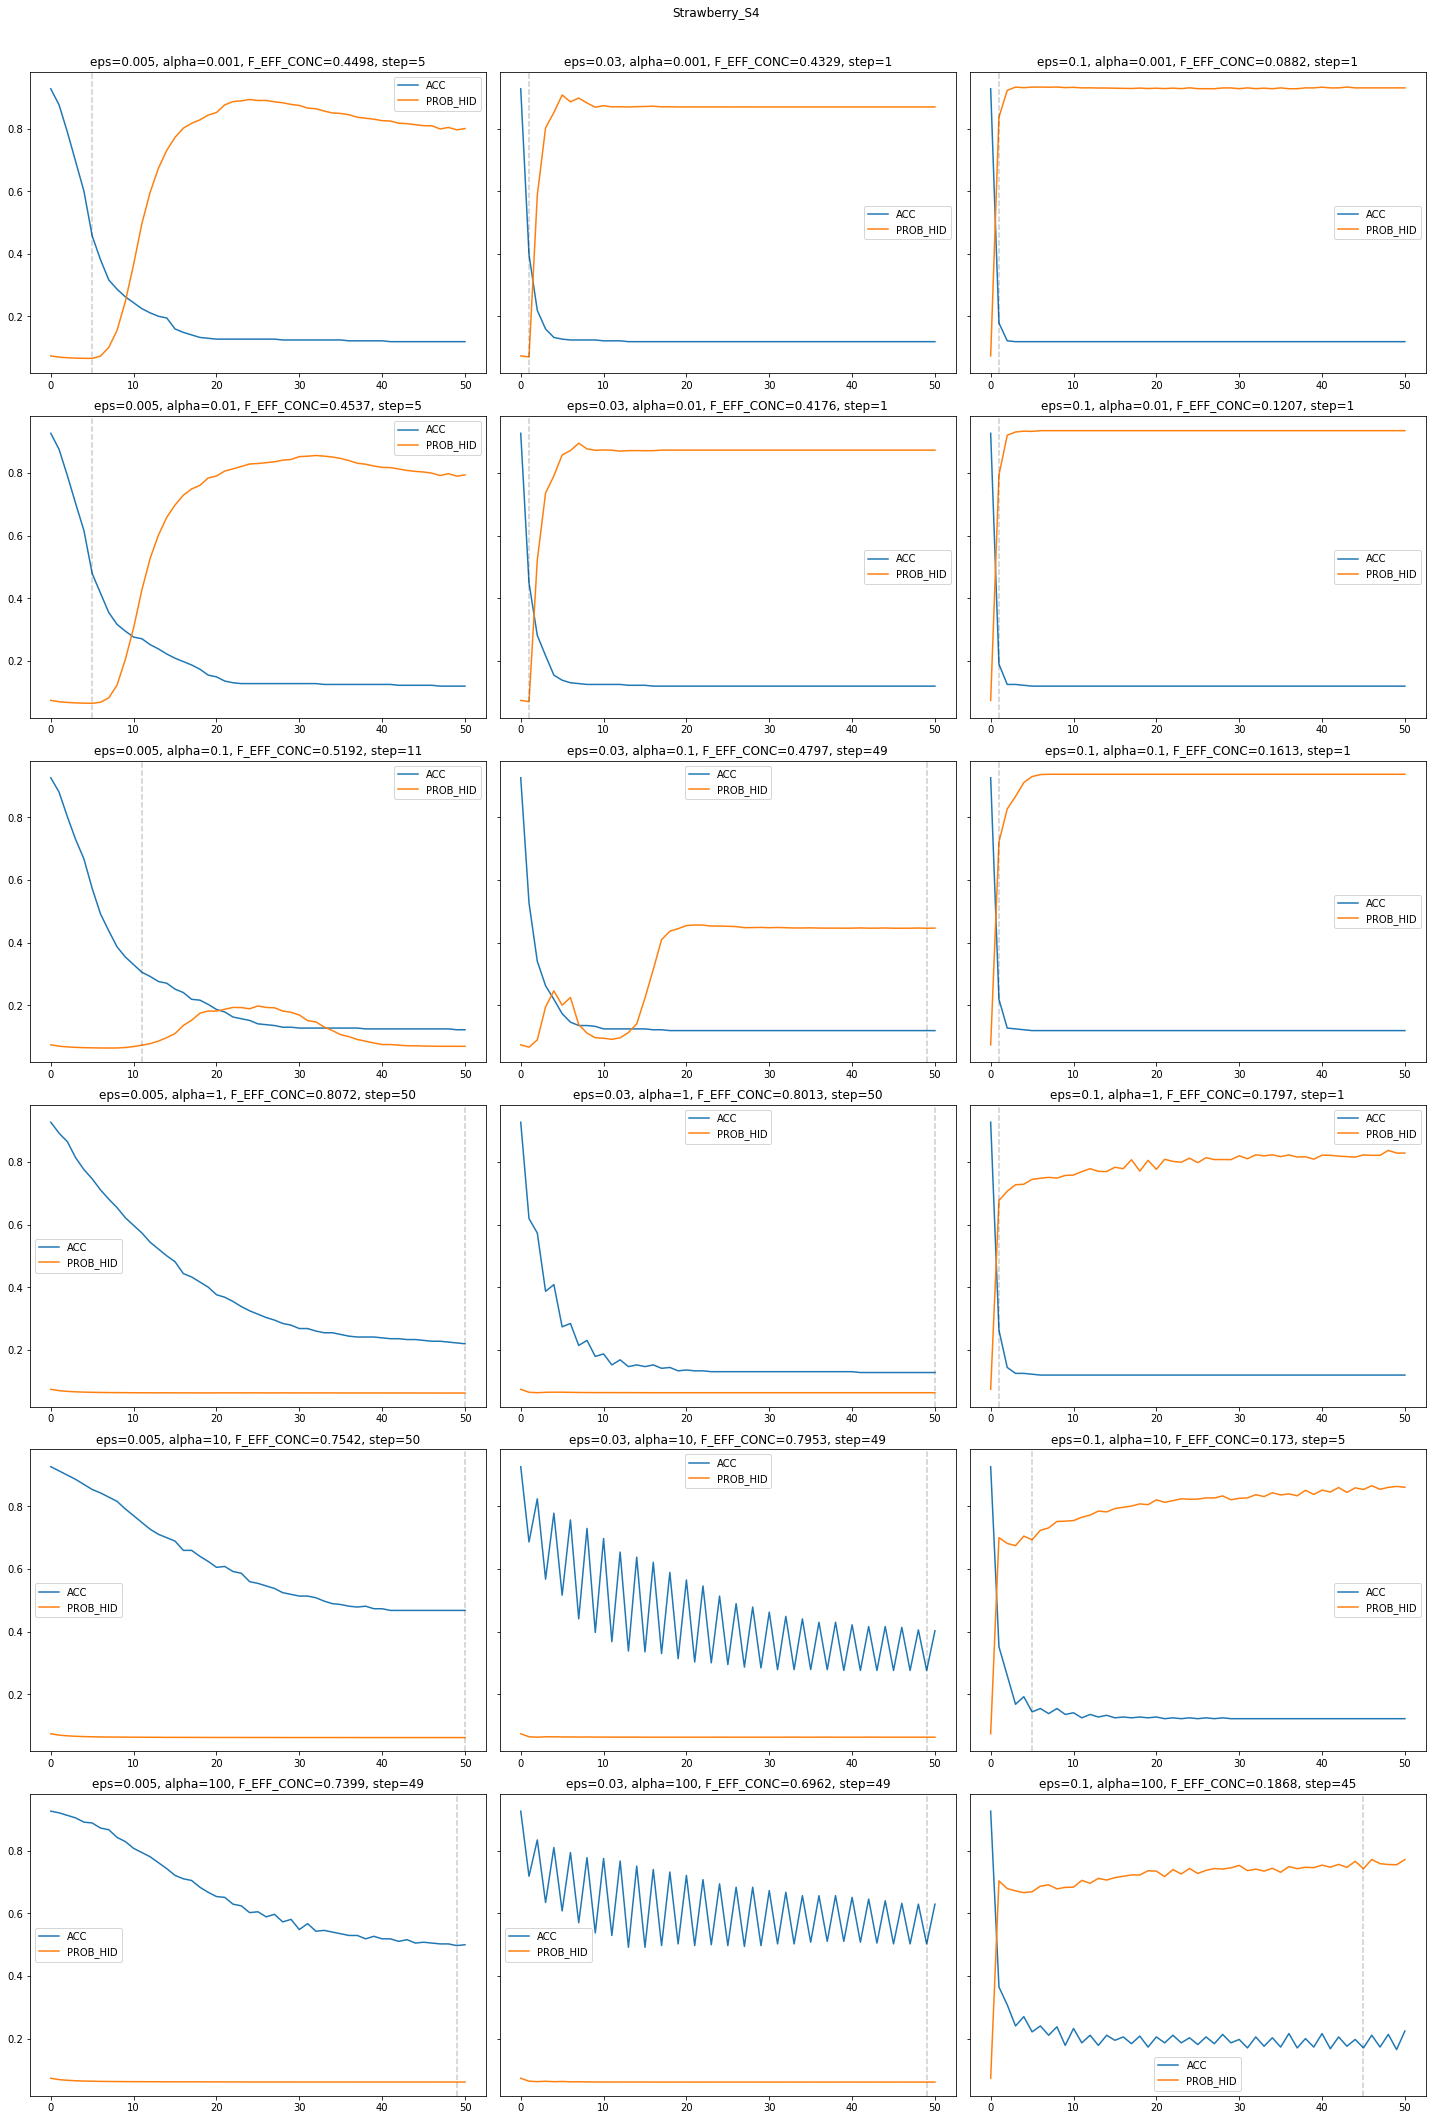

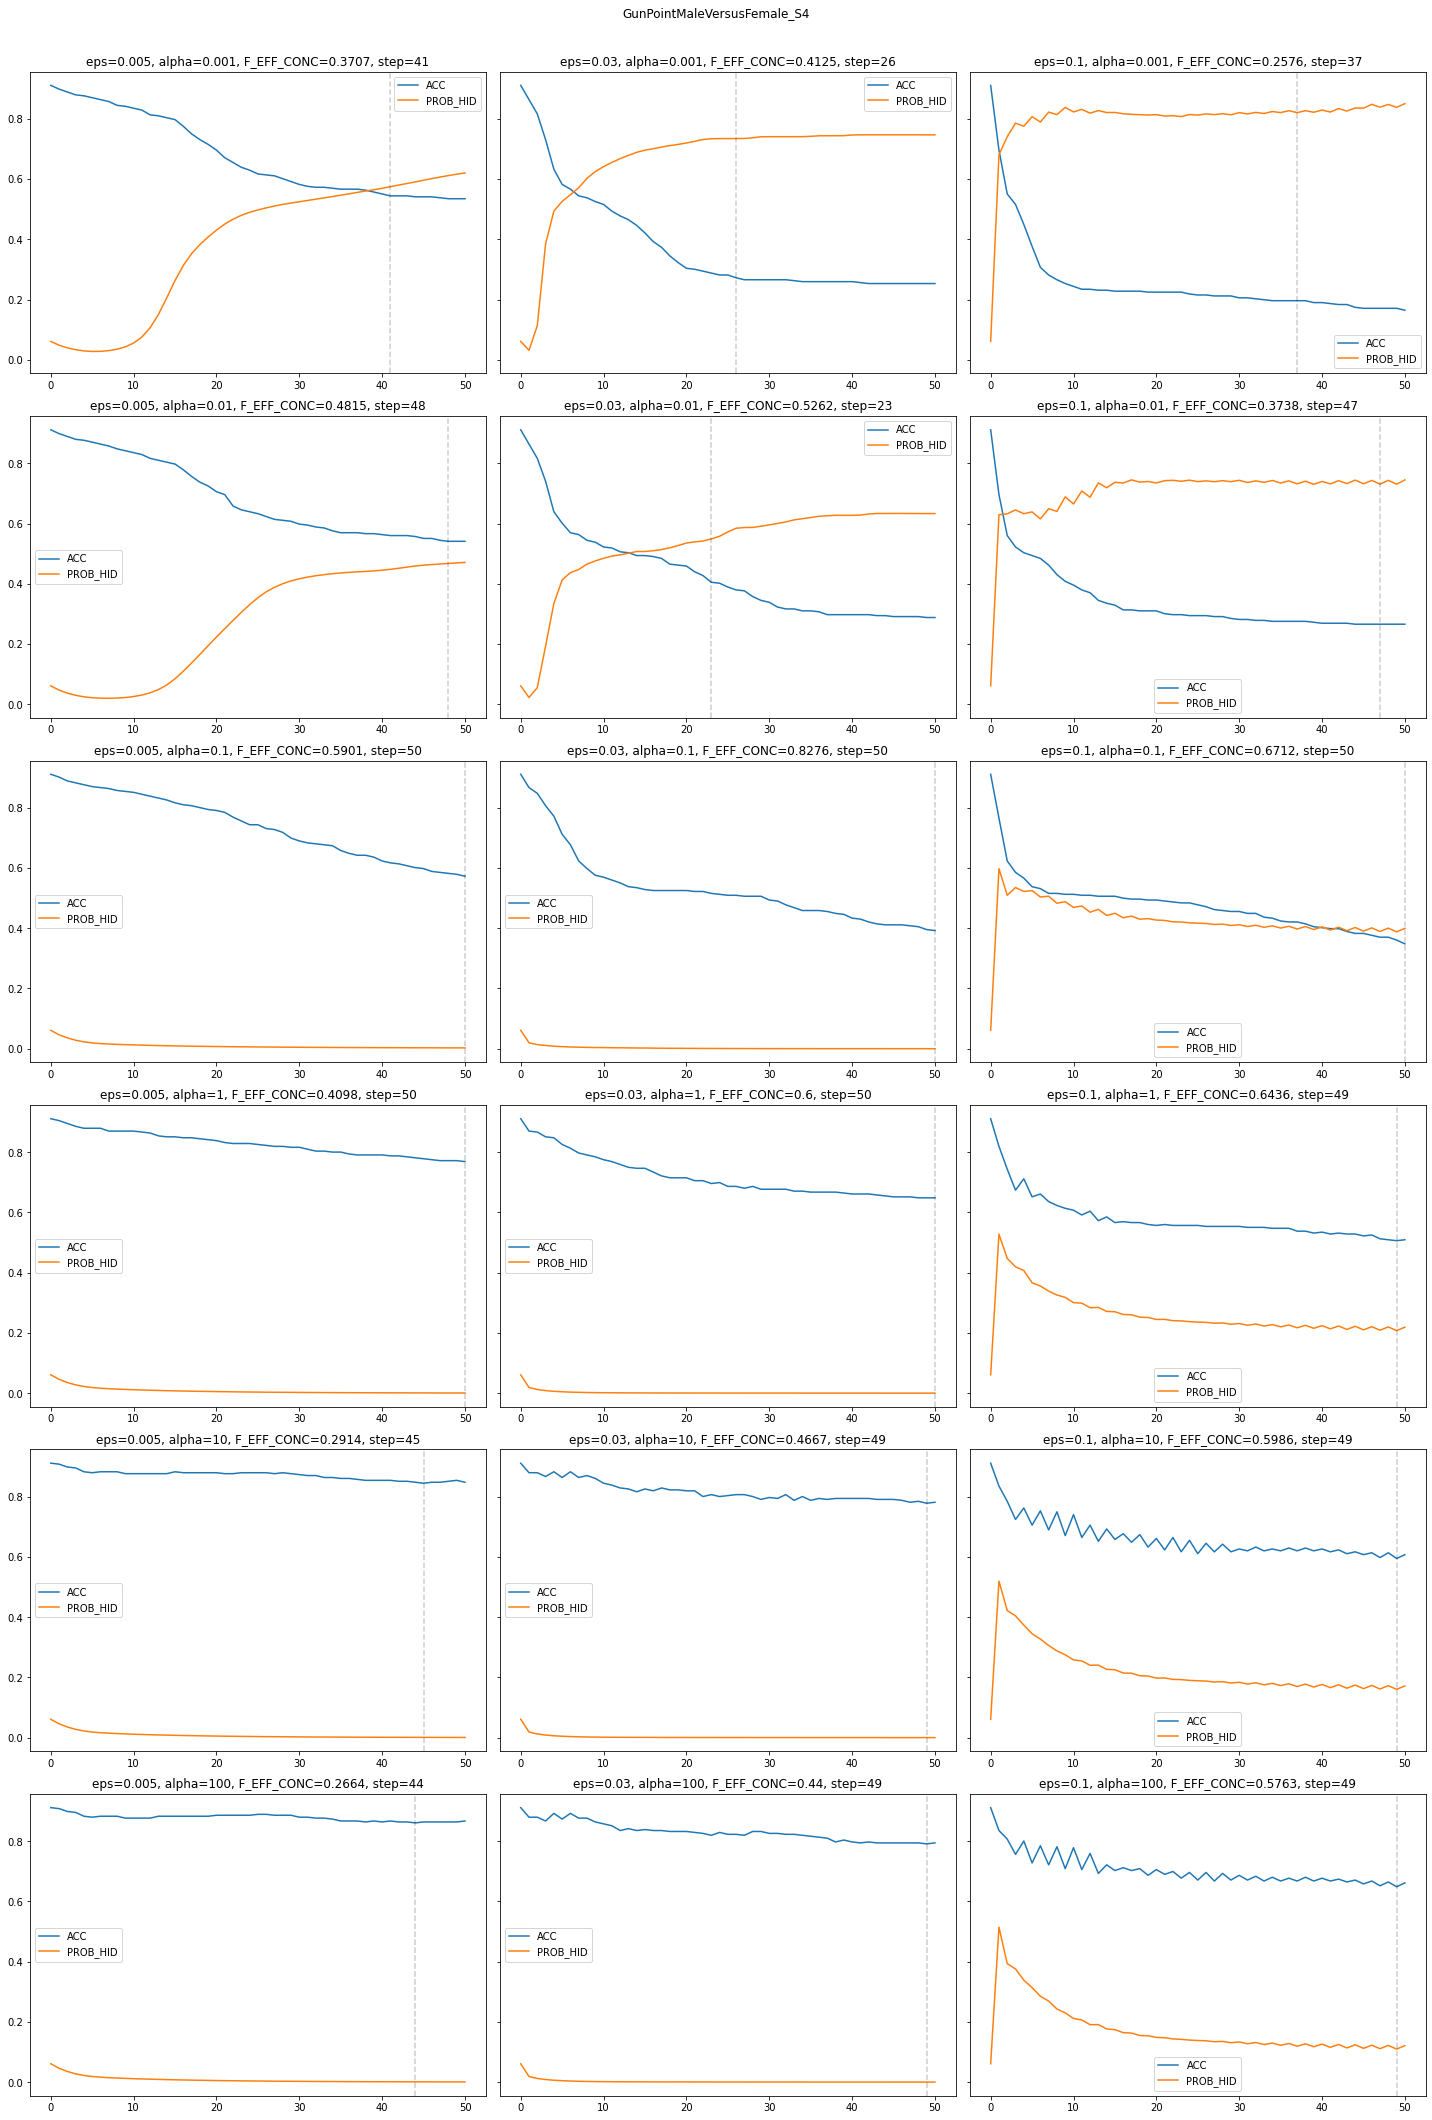

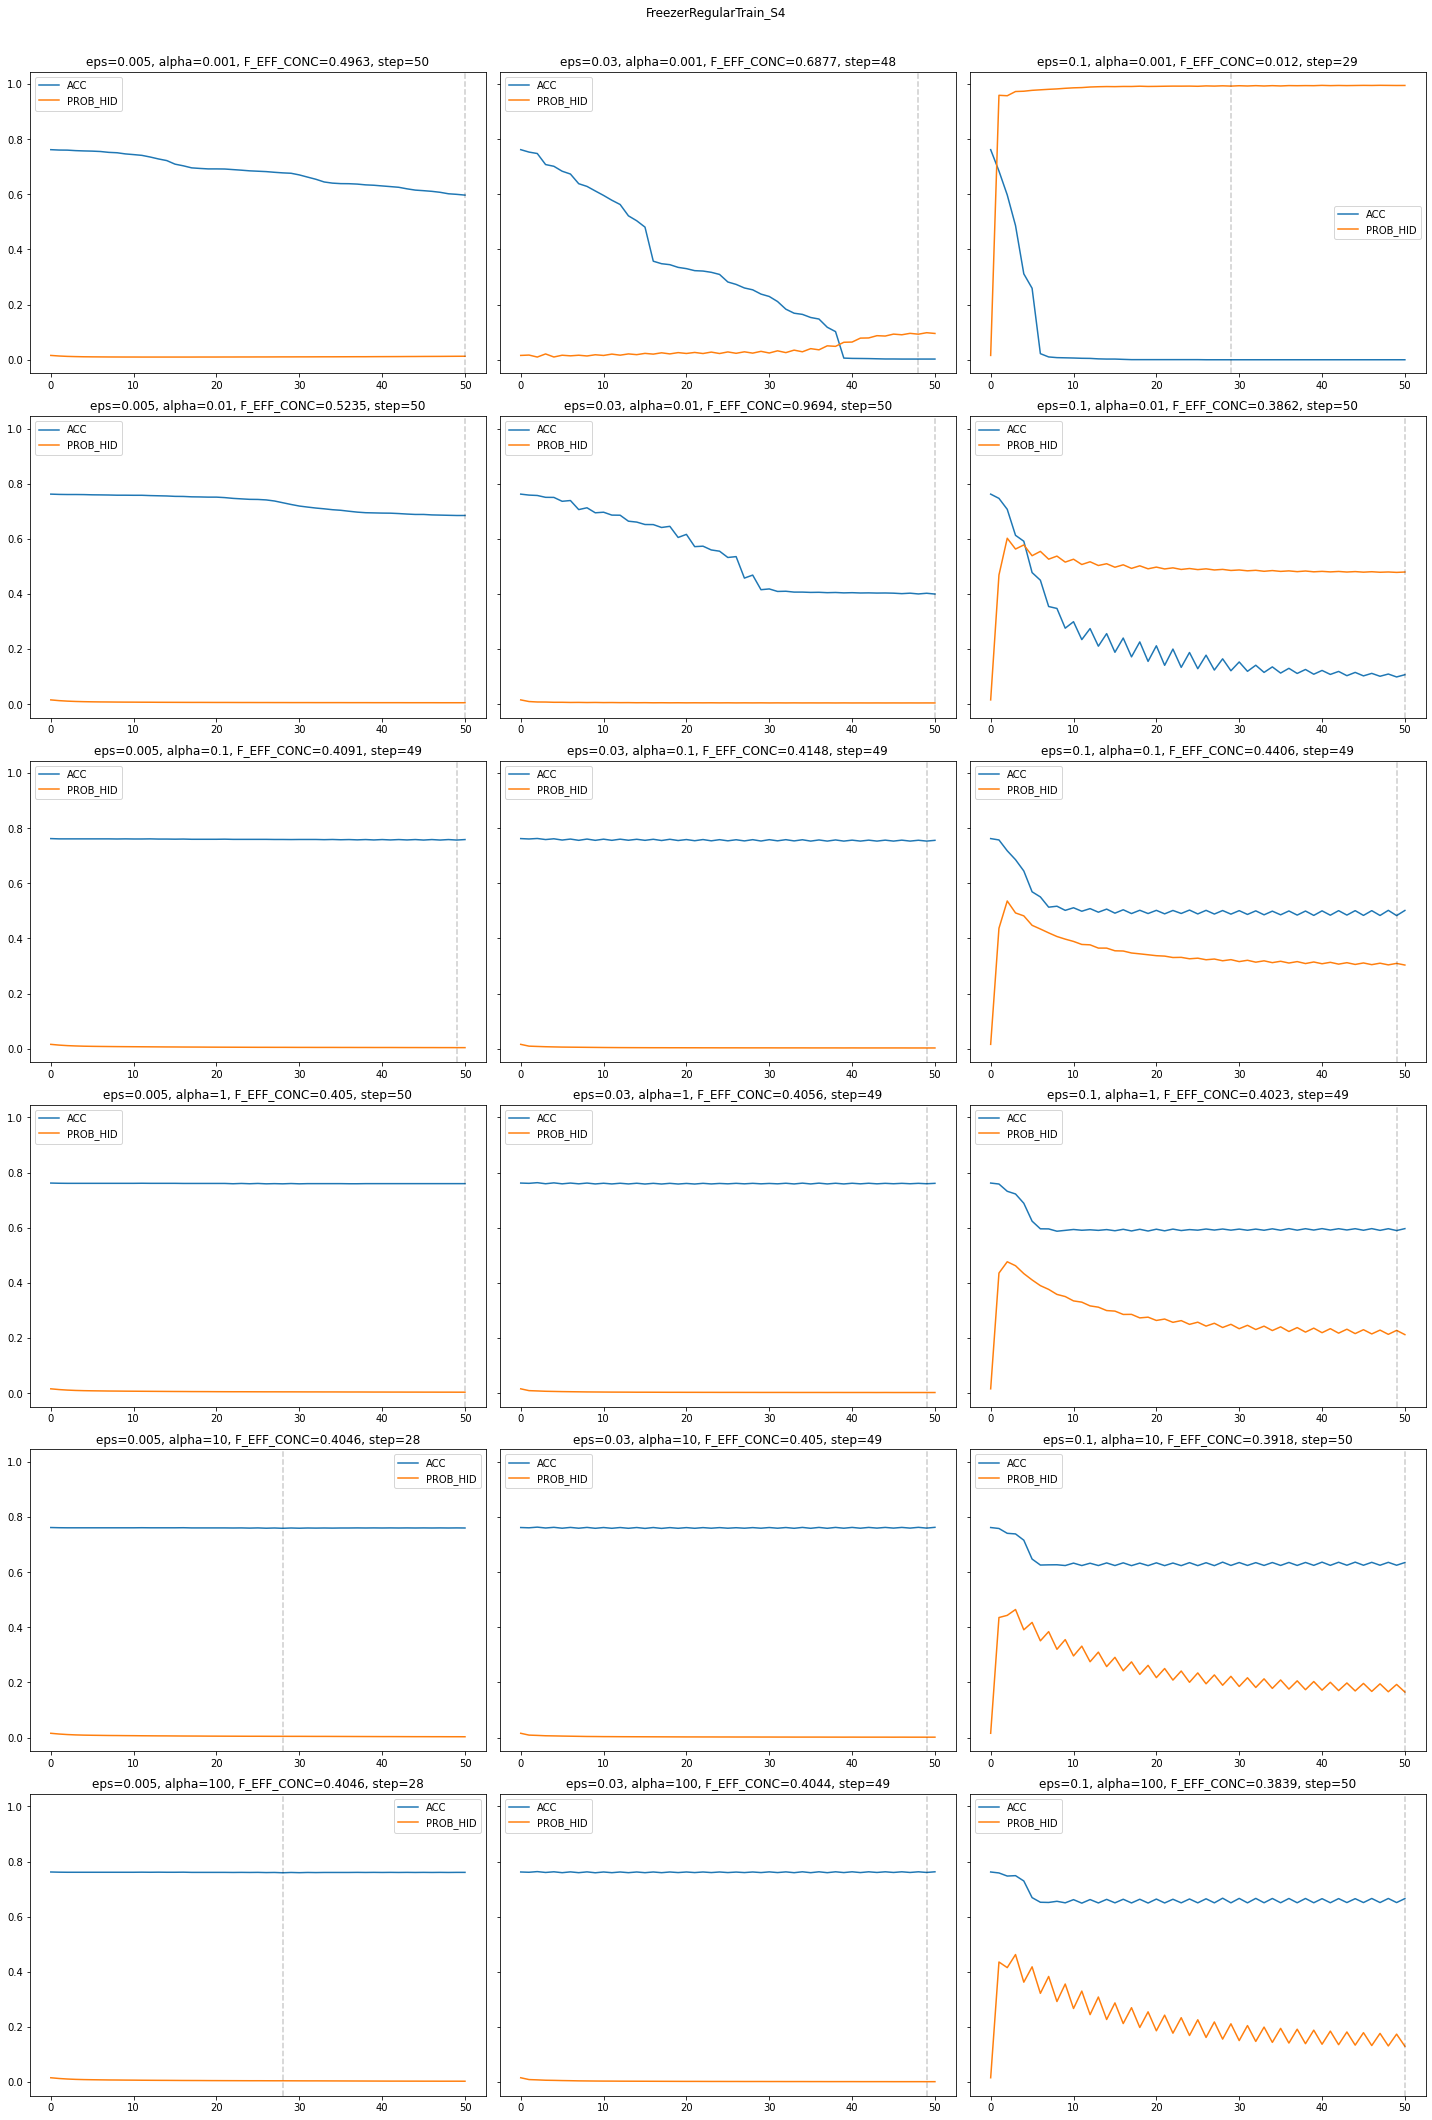

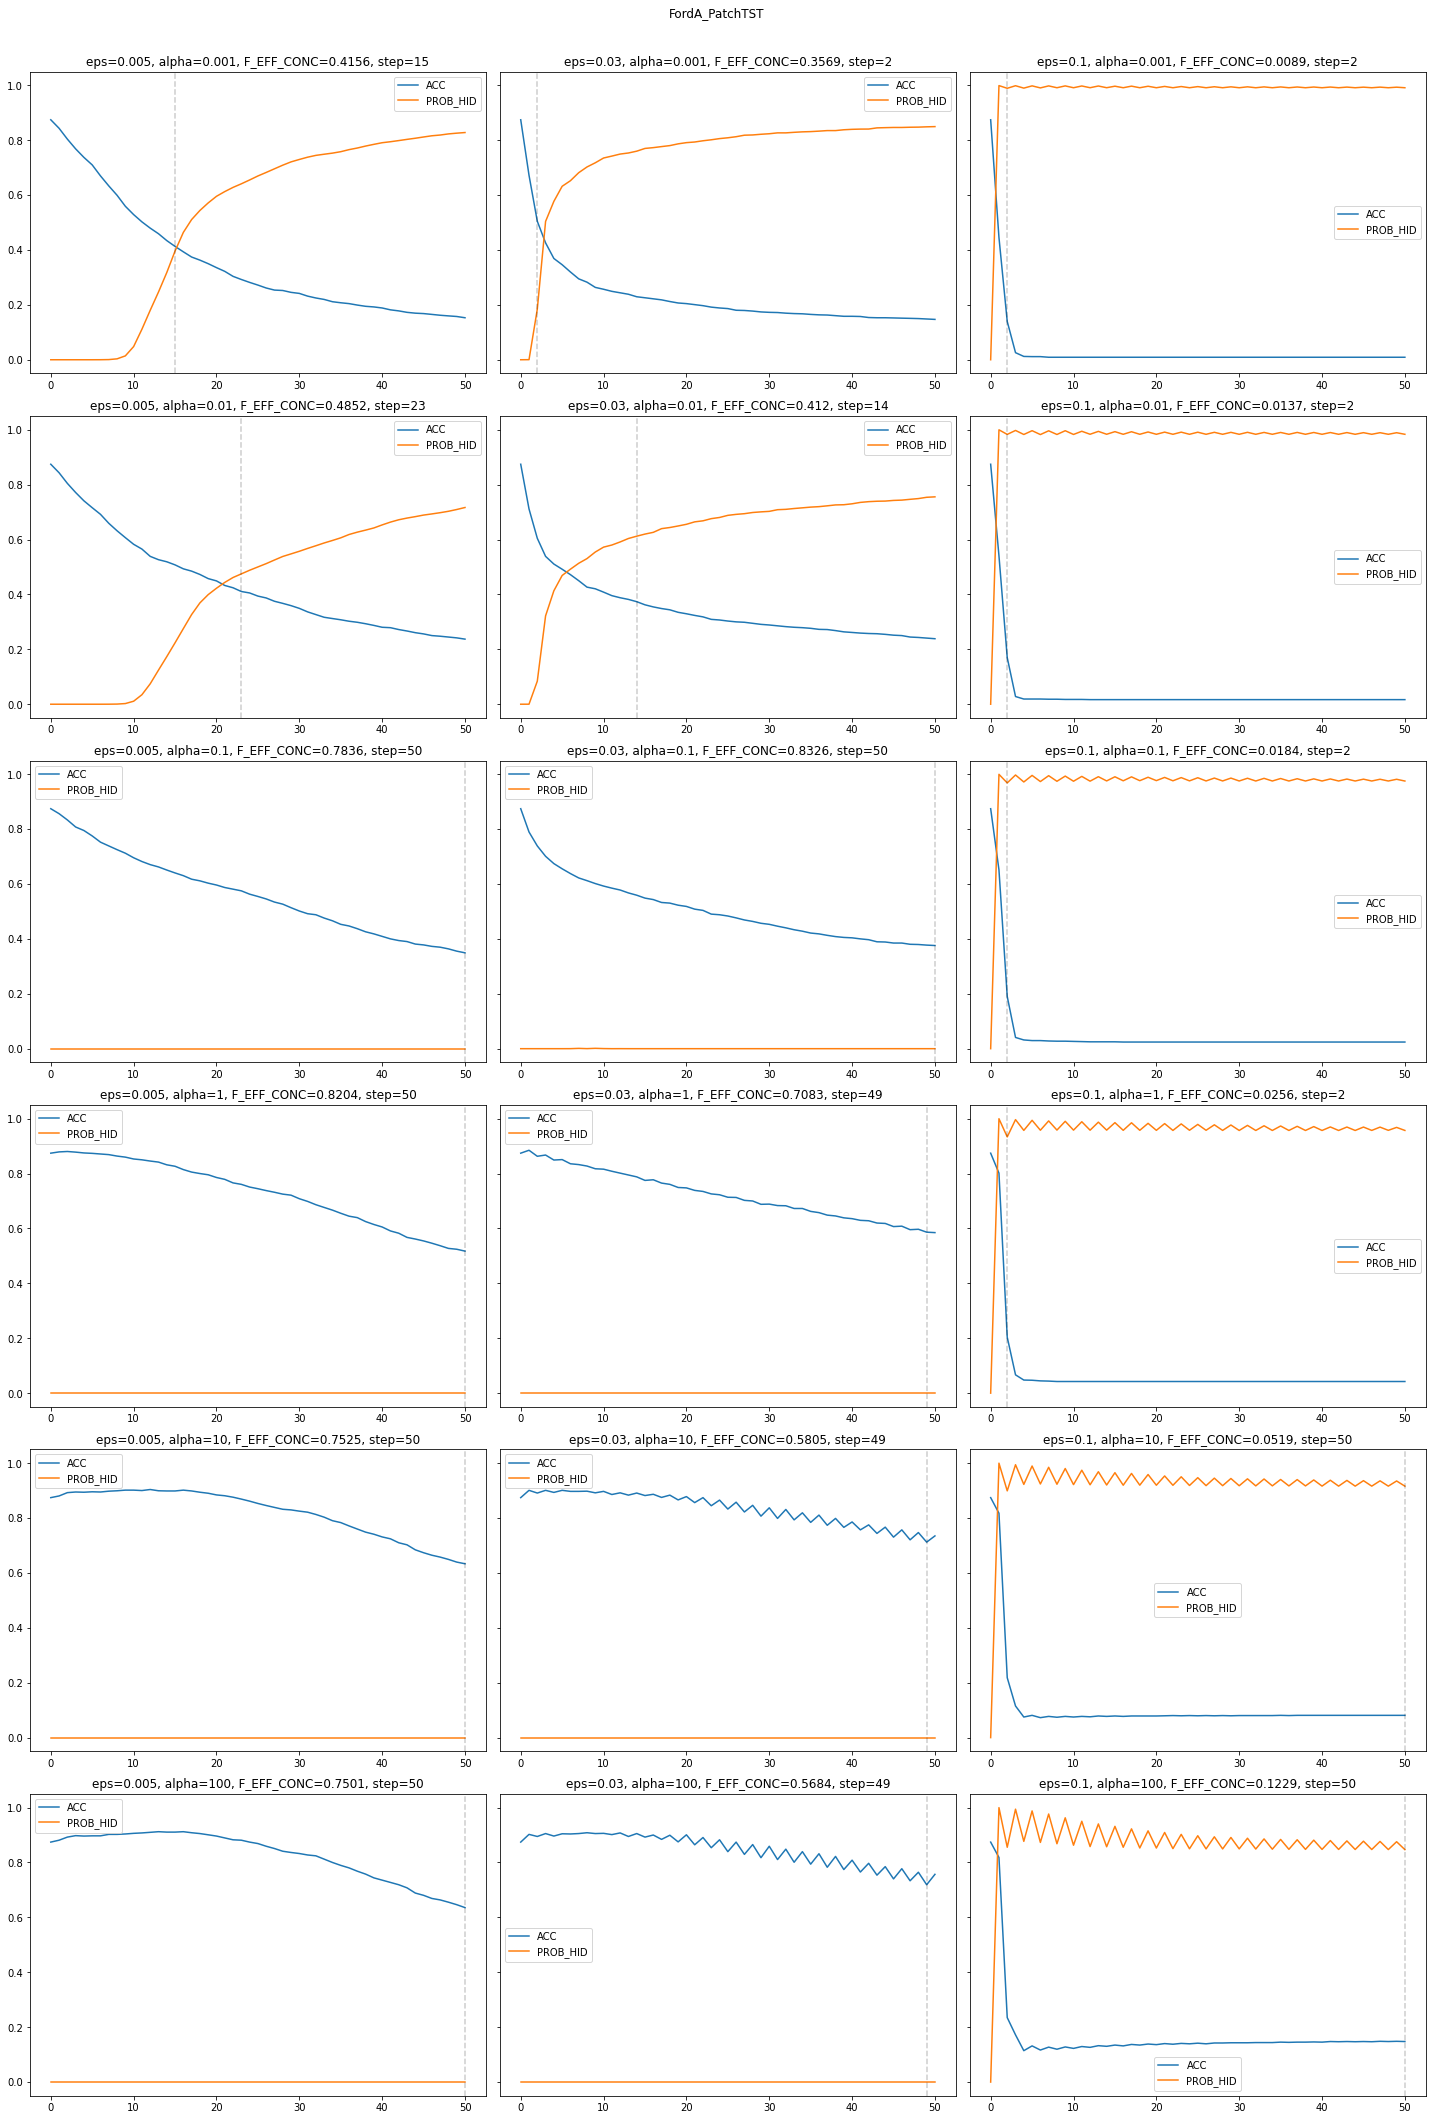

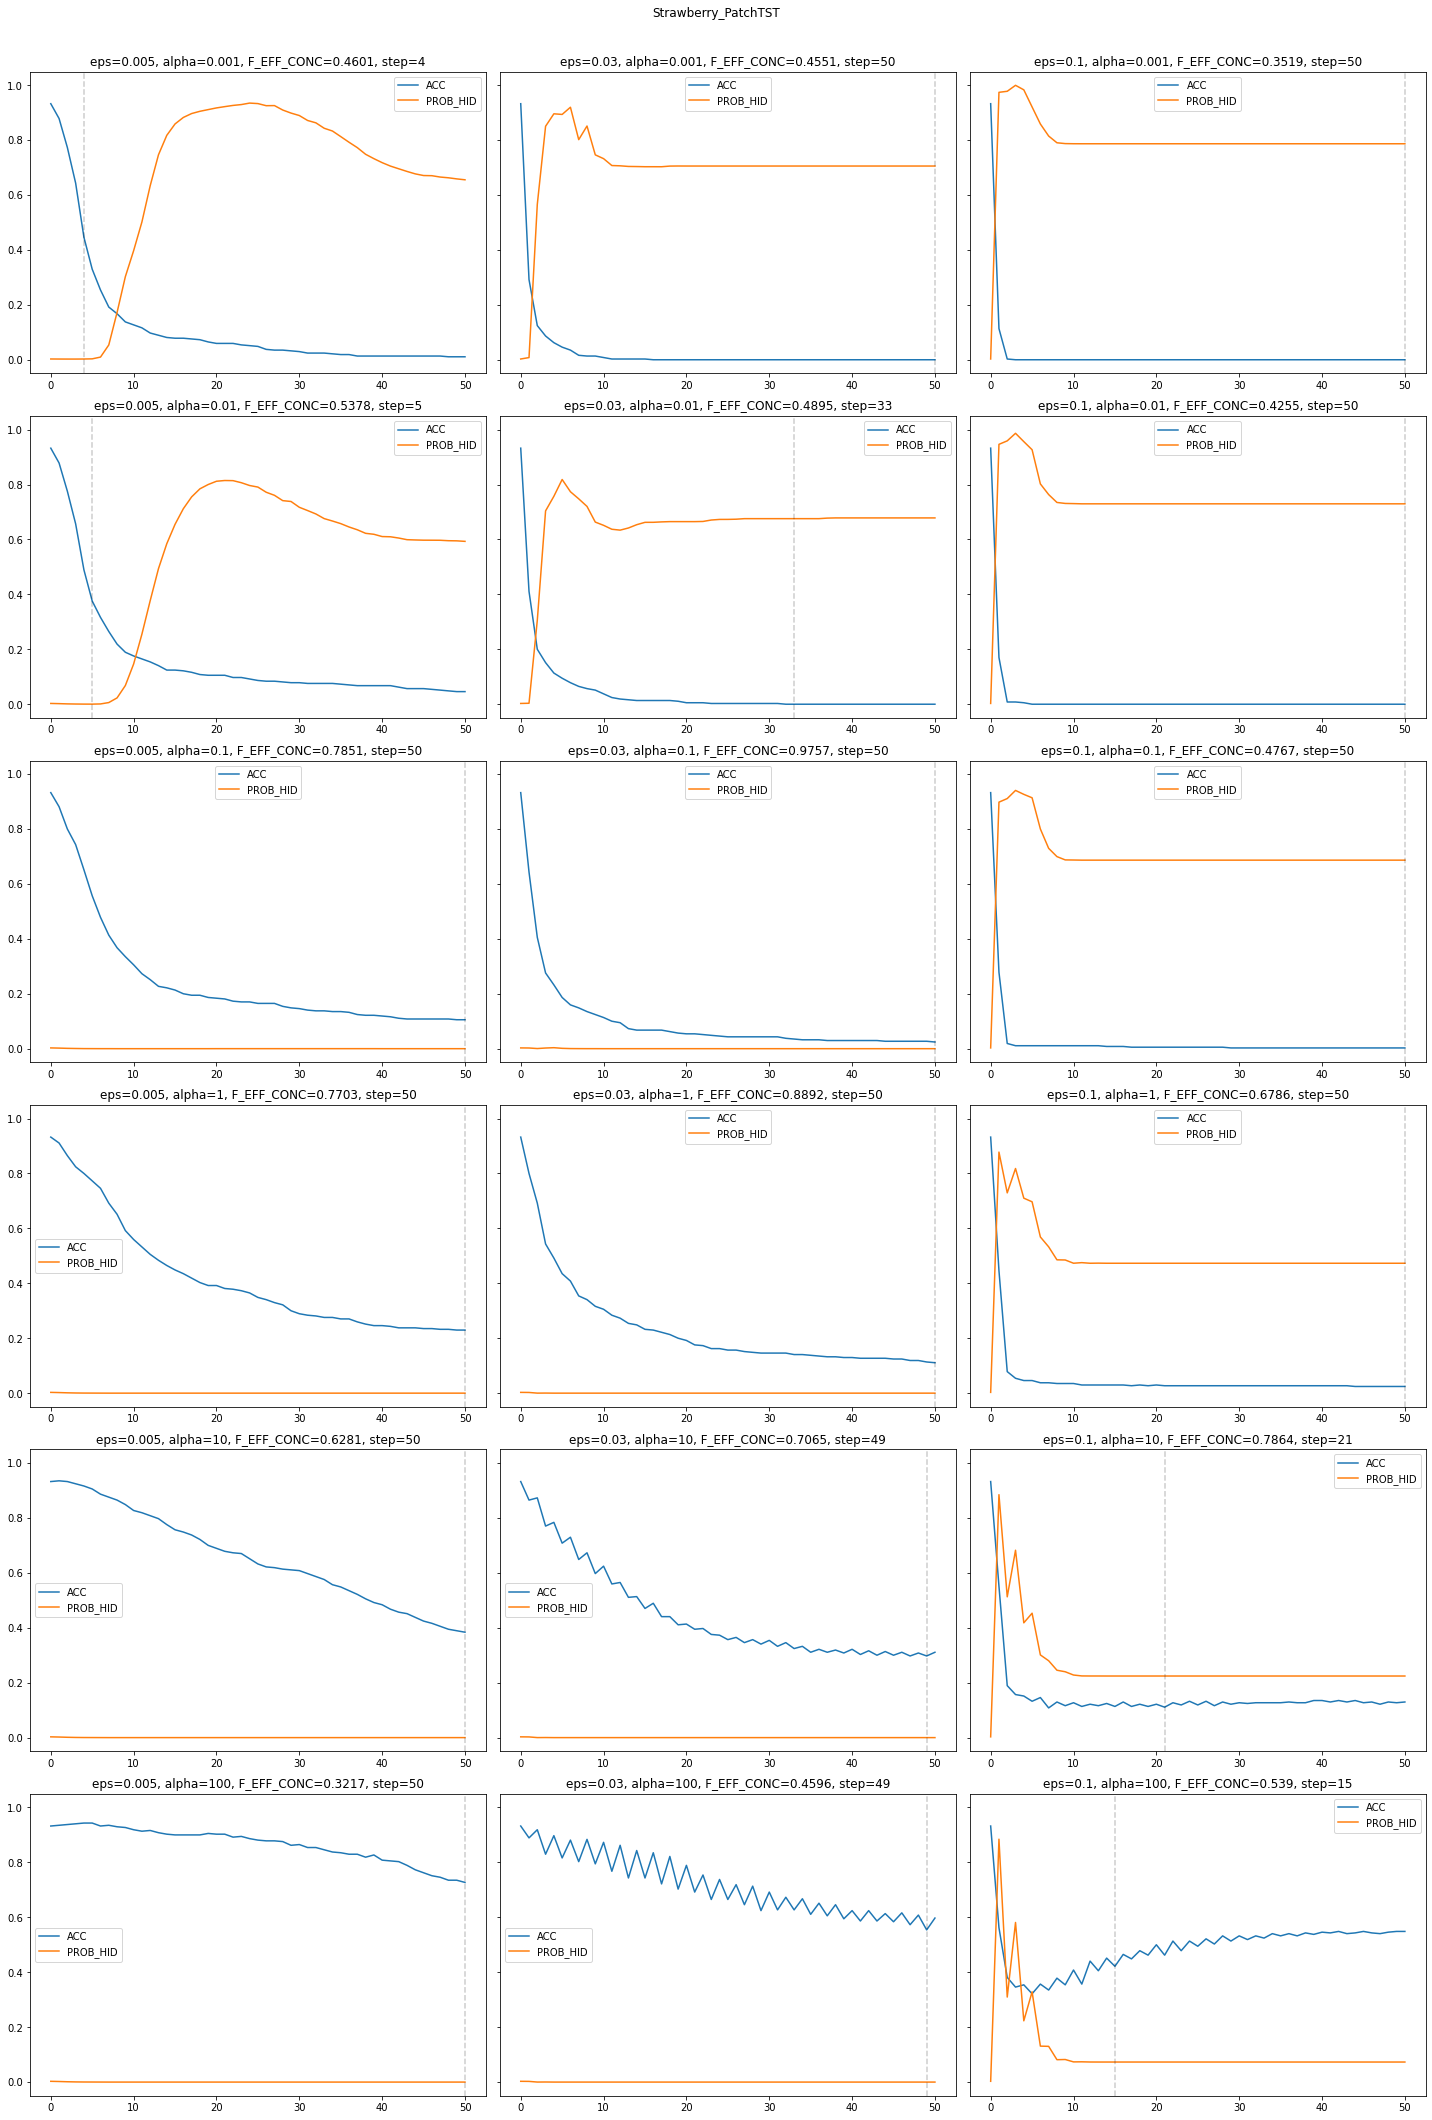

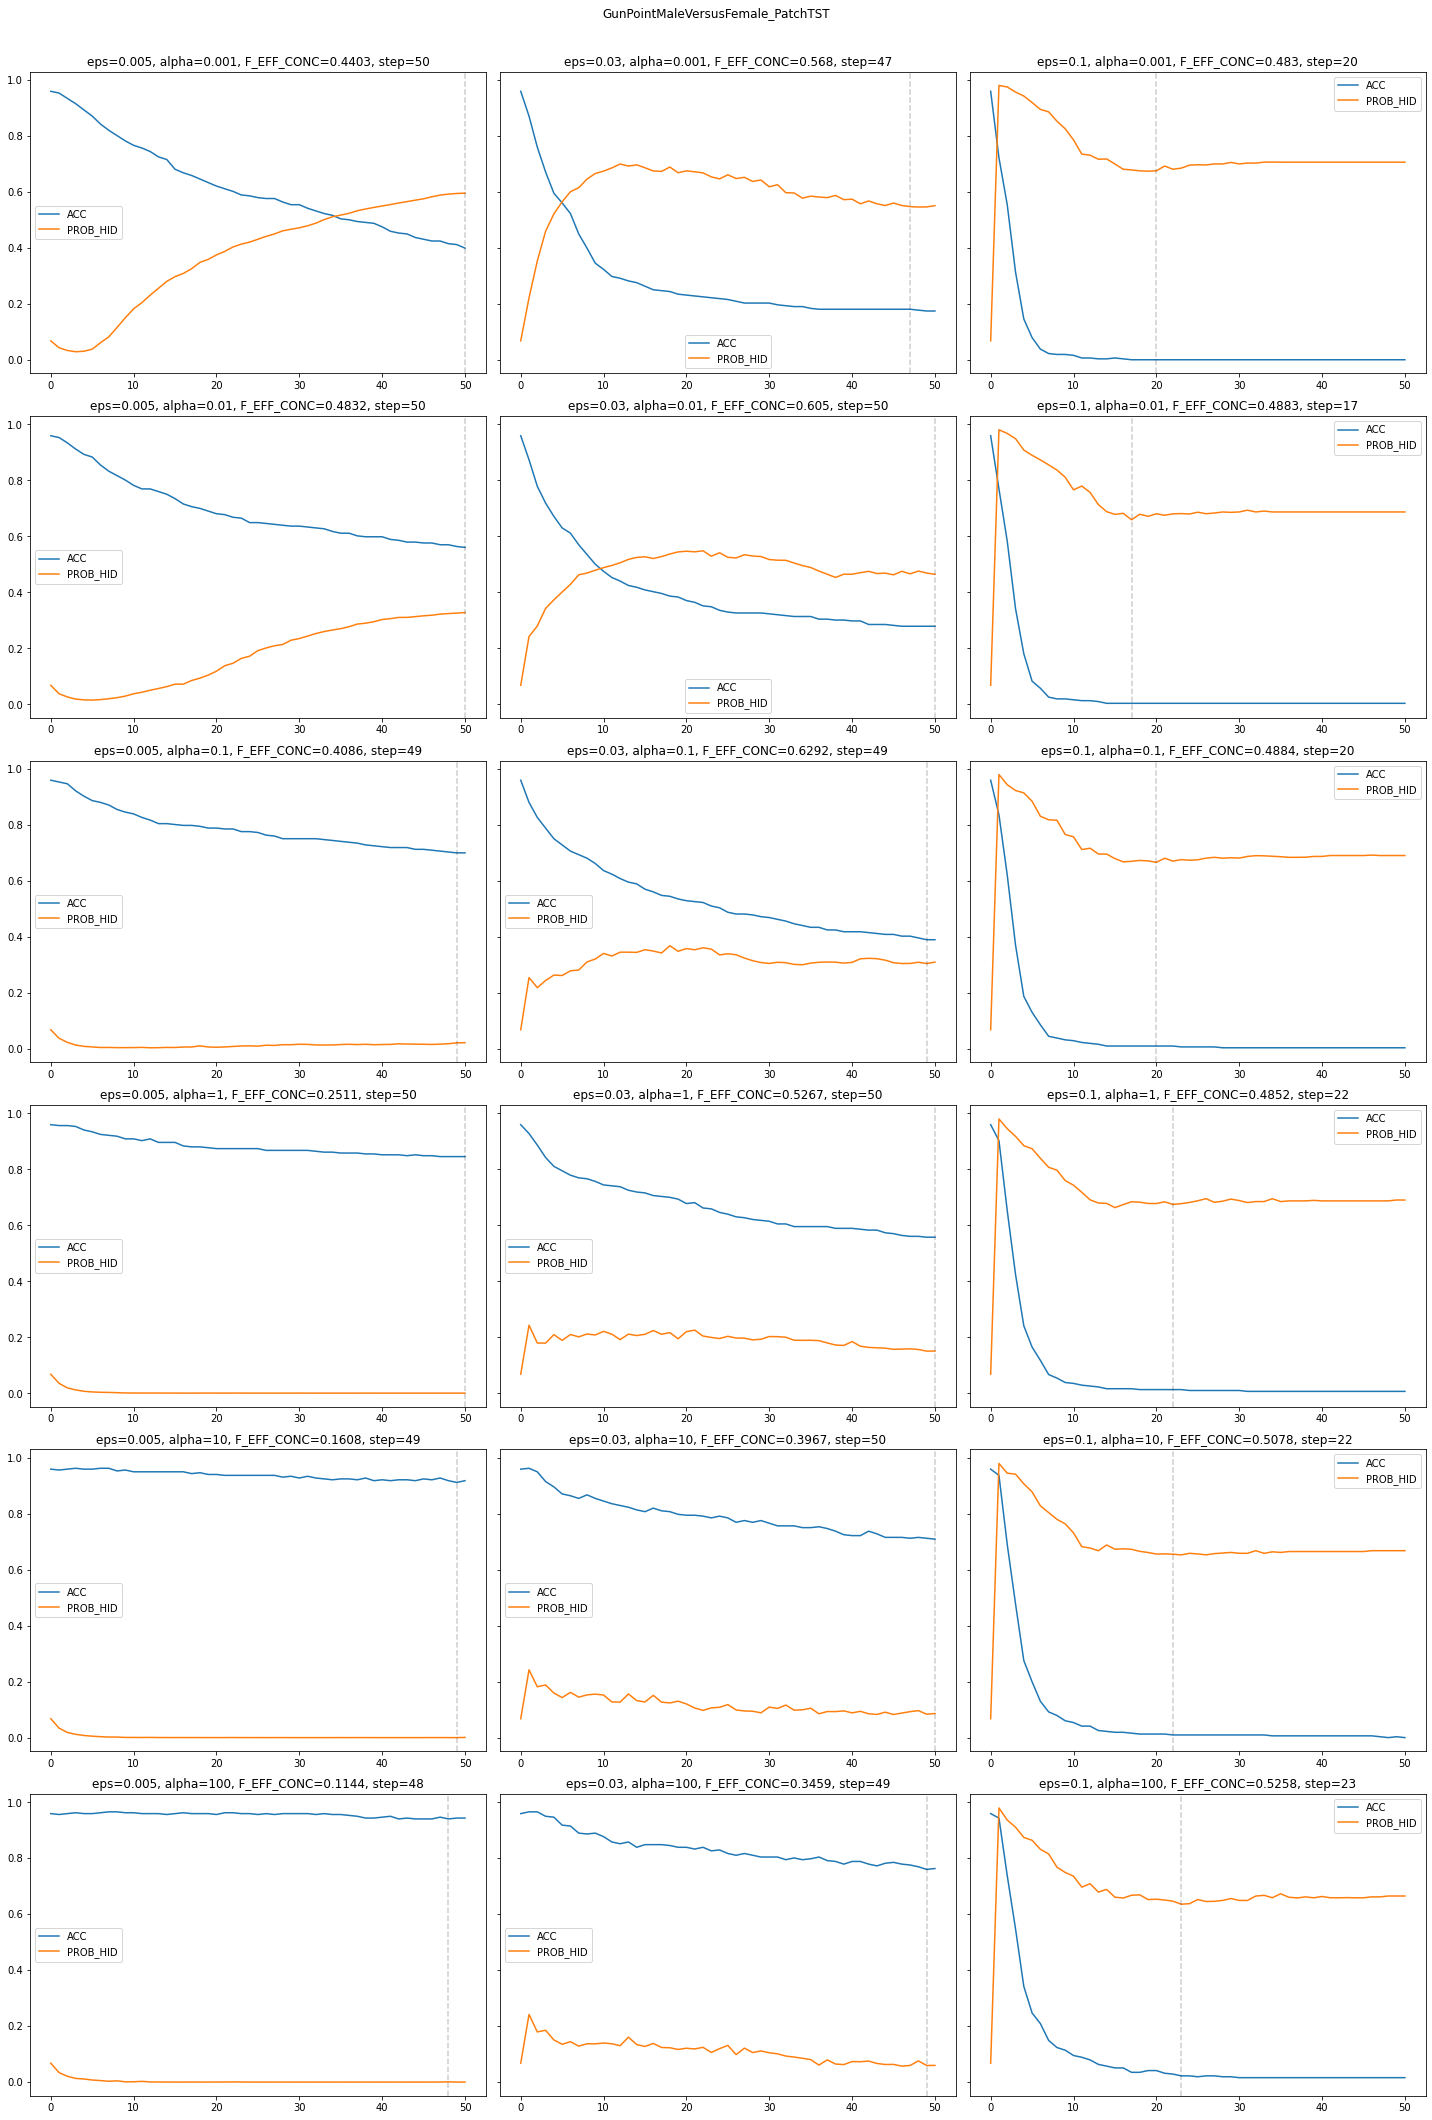

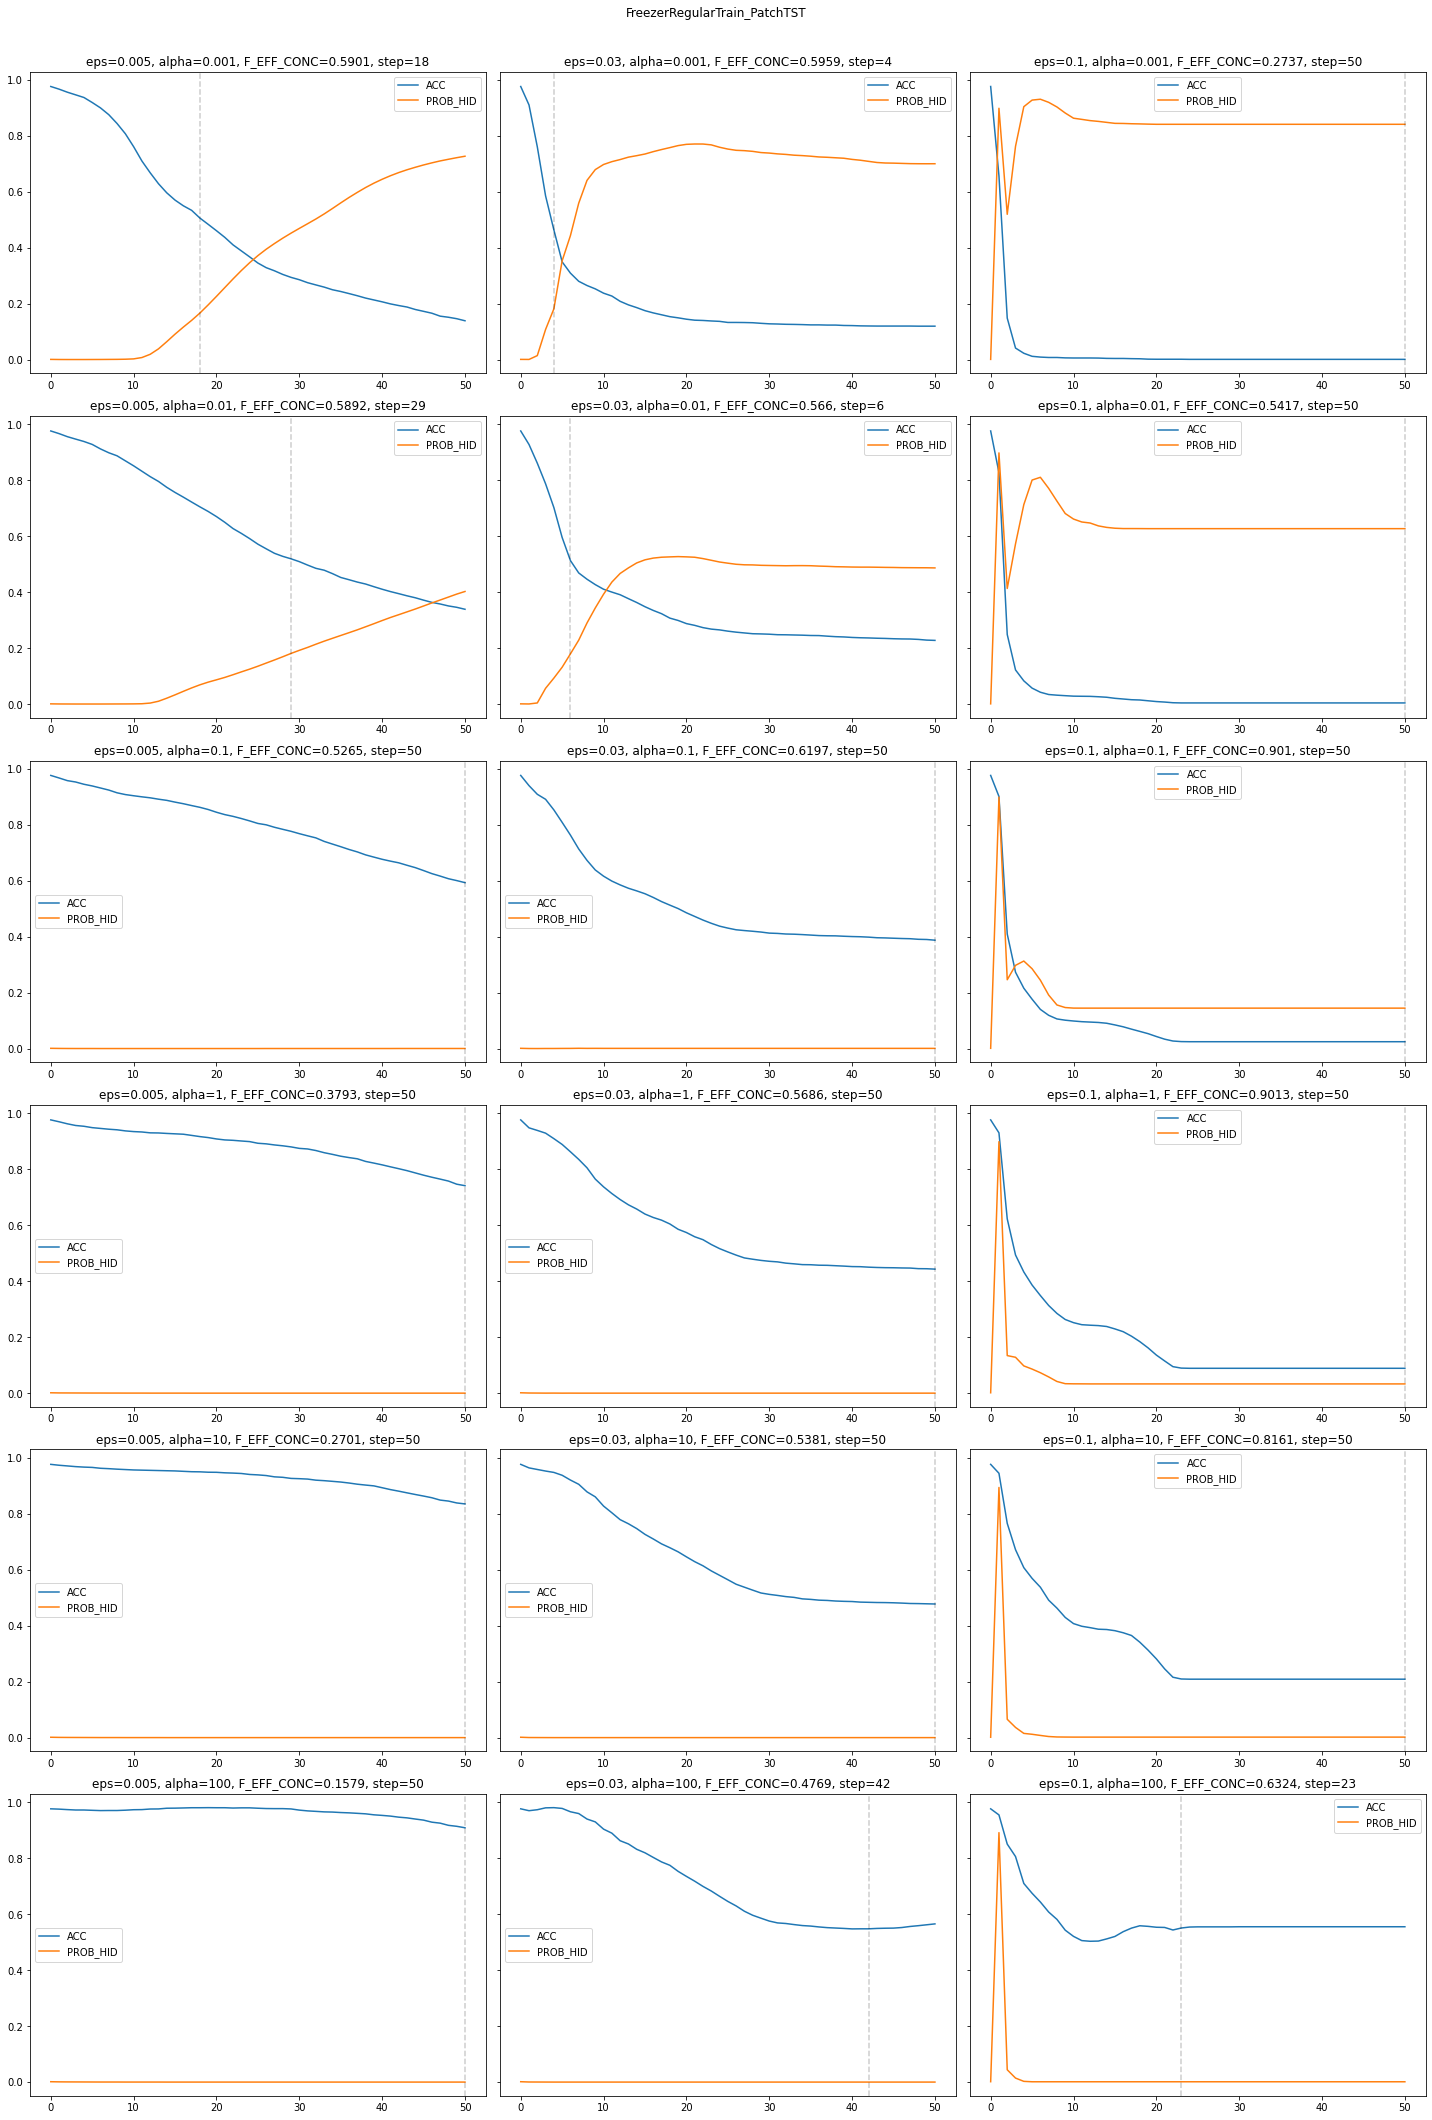

In [277]:
for model in ['LSTM', 'ResidualCNN', 'RNNA', 'TST', 'S4', 'PatchTST']:
    for ds in ['FordA', 'Strawberry', 'GunPointMaleVersusFemale', 'FreezerRegularTrain']:
        try:
            aa = aggregated_results(dataset=ds, model_name=model, exp_name="CLEAN", vis=True, save_pic=True)
        except:
            print(ds, model)